### Import packages

In [4]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Params

In [5]:
is_log_target = True
is_per_area_target = True
is_embedding = True
is_tar_encoded = False

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]
cols_num_add = ['land_per_building_area']
cols_cat_add = ['encoded_latlon']
cols_bin_add = []

# cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

rare_village_threshold = 1
rare_town_threshold = 1

print('Target:', col_target)

Target: log_per_area_total_price


### Columns

In [6]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']

cols_num = [c for c in cols_num if c not in cols_feats_rm]
cols_bin = [c for c in cols_bin if c not in cols_feats_rm]
cols_cat = [c for c in cols_cat if c not in cols_feats_rm]
#cols_feats_add = [c for c in cols_feats_add if c not in cols_feats_rm]

#cols_feats = cols_num + cols_cat + cols_bin + cols_feats_add

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']

# right skew cols
#cols_right_skew = ['parking_area', 'land_area', 'building_area']+[c for c in cols_num if 'MIN' in c]

# For Stratified train test split
#cols_stratified = ['town', 'village']

print('Num:', len(cols_num), 'Bin:', len(cols_bin), 'Cat:', len(cols_cat))
print('Add:', len(cols_num_add), len(cols_bin_add), len(cols_cat_add))
#print('Right skew:', cols_right_skew)
#print('Total:', len(cols_feats))

Num: 155 Bin: 49 Cat: 7
Add: 1 0 1


### Read data

In [7]:
train = pd.read_csv('dataset/train.csv', dtype=object)
test = pd.read_csv('dataset/test.csv', dtype=object)
train.head(5)
test.head(5)

id_cv = []
for i in range(5):
    id_one_fold = pd.read_csv(f'dataset/id_cv{i}.csv', dtype=object)['building_id']
    id_cv.append(id_one_fold)

### Preprocessing

In [8]:
def pre_processing(df, cols_num, cols_cat, cols_bin):
    """Preprocess (inplace) that are independent of train and validatoin set"""
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    df[cols_bin] = df[cols_bin].astype('float32')
    df[cols_cat] = df[cols_cat].astype('int32')
    
    # target transform base (store this for inverse transform)
    if is_per_area_target:
        df['building_area_ori'] = df['building_area']
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area_ori']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['land_per_building_area'] = df['land_area'] / df['building_area']
    
    # label for stratified train test split
    #df['stratified'] = 
    
    return df

In [9]:
def post_processing(y_pred, df):
    """Post processing target
       Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area_ori'].values
        
    return y_pred_final

In [10]:
train = pre_processing(train, cols_num, cols_cat, cols_bin)
test = pre_processing(test, cols_num, cols_cat, cols_bin)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [11]:
# Add those added feature columns (run this after preprocess has done)
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_bin = cols_bin + [c for c in cols_bin_add if c not in cols_bin]
cols_feats = cols_num + cols_cat + cols_bin
print('Feat columns:', len(cols_feats))

# Target mean encoded columns
cols_tar_encoded = ['encoded_'+c for c in cols_cat] if is_tar_encoded else []
    
print('\nTarget mean encoded columns:', len(cols_tar_encoded))

# Compute skew columns
cols_right_skew = [c for c in cols_num if train[c].skew() > 2.2]
print('\nRight skew columns:', len(cols_right_skew))

# Fillna values for null columns
fillna_values = {
    'parking_area': -1.,
    'parking_price': -1.,
    'txn_floor': 0.,
    #'village_income_median': 'median',
}

Feat columns: ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_

#### Check

In [17]:
train[cols_feats].check()

,txn_dt,total_floor,building_complete_dt,parking_area,parking_price,txn_floor,land_area,building_area,lat,lon,...,XII_index_500,XII_index_1000,XIII_index_50,XIII_index_500,XIII_index_1000,XIII_index_5000,XIII_index_10000,XIV_index_50,XIV_index_500,XIV_index_1000
0,18674.0,4.0,6271.0,NaN,NaN,3.0,18.144461,3.418175,-39.139999,117.080002,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,18800.0,5.0,7885.0,NaN,NaN,5.0,11.387227,4.041309,-37.660000,119.279999,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,19289.0,4.0,6028.0,NaN,NaN,1.0,21.426802,5.584279,-37.669998,119.290001,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
3,20385.0,24.0,18325.0,NaN,81138.890625,13.0,11.387227,13.563030,-39.130001,117.089996,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
4,20657.0,2.0,6880.0,NaN,NaN,NaN,61.306522,4.688108,-39.240002,117.190002,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
59995,19040.0,2.0,9193.0,NaN,NaN,NaN,50.917366,6.754059,-39.220001,117.269997,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
59996,19706.0,14.0,17168.0,3.738412,133729.234375,7.0,4.181031,5.356788,-37.650002,119.370003,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
59997,19901.0,11.0,13729.0,NaN,61488.570312,6.0,11.387227,8.223644,-37.669998,119.309998,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
59998,19975.0,5.0,7063.0,NaN,NaN,3.0,23.049440,8.728287,-37.639999,119.379997,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
59999,20385.0,5.0,8310.0,NaN,NaN,4.0,16.482126,5.356788,-37.669998,119.300003,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


shape = (60000, 213)


In [18]:
test[cols_feats].check()

,txn_dt,total_floor,building_complete_dt,parking_area,parking_price,txn_floor,land_area,building_area,lat,lon,...,XII_index_500,XII_index_1000,XIII_index_50,XIII_index_500,XIII_index_1000,XIII_index_5000,XIII_index_10000,XIV_index_50,XIV_index_500,XIV_index_1000
0,18634.0,2.0,1857.0,NaN,NaN,NaN,40.317787,3.418175,-37.720001,119.449997,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
1,20199.0,10.0,16011.0,NaN,NaN,2.0,18.144461,7.726227,-37.700001,119.169998,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2,19769.0,4.0,18294.0,NaN,NaN,NaN,47.912743,12.170581,-38.029999,118.239998,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
3,20479.0,19.0,17837.0,NaN,NaN,16.0,2.222000,2.252256,-37.700001,119.339996,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,18164.0,13.0,13272.0,NaN,NaN,3.0,11.387227,5.813985,-37.740002,119.589996,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
9995,19494.0,6.0,12115.0,NaN,NaN,4.0,14.803422,7.236278,-37.750000,119.589996,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
9996,19166.0,13.0,17502.0,8.65435,133729.234375,2.0,18.144461,13.001777,-37.709999,119.379997,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9997,19340.0,3.0,11324.0,NaN,NaN,NaN,41.847099,8.223644,-39.230000,117.250000,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
9998,18184.0,5.0,7885.0,NaN,NaN,2.0,11.387227,3.830869,-37.700001,119.309998,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
9999,20370.0,6.0,11142.0,NaN,NaN,6.0,21.426802,11.623768,-39.169998,117.129997,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0


shape = (10000, 213)


#### Skew check

parking_area 38.44056 7.870601


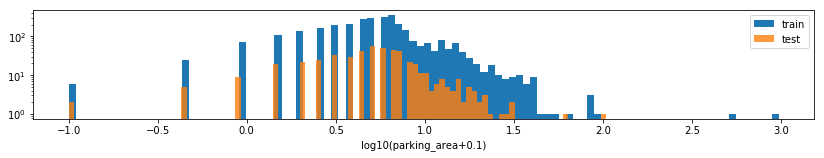

parking_price 3.9744008 2.3863173


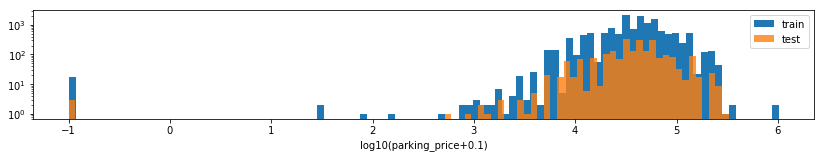

land_area 43.667255 13.955456


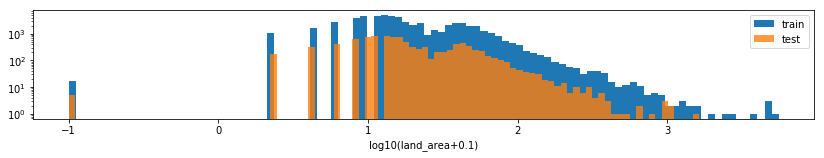

building_area 83.71063 68.803505


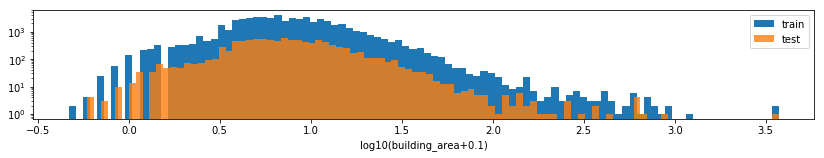

village_income_median 2.8121378 2.7584677


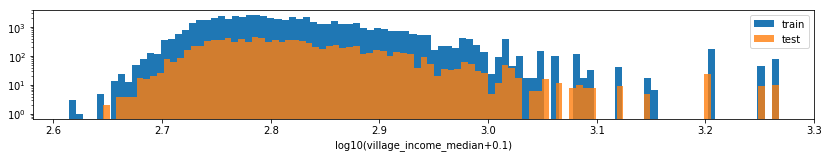

I_10 15.562963 13.761168


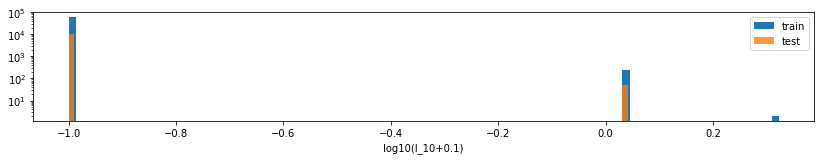

I_50 4.59847 5.175877


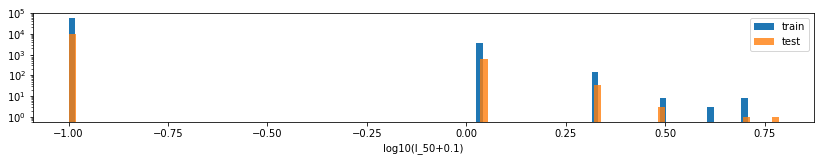

I_100 3.0459154 2.952237


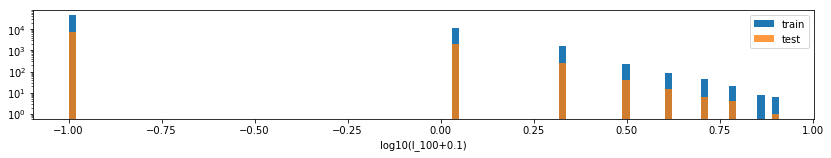

I_MIN 2.7619326 2.7186675


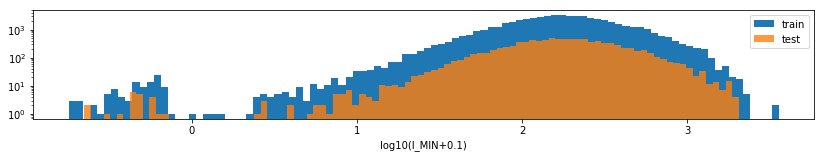

II_10 6.9647446 6.782957


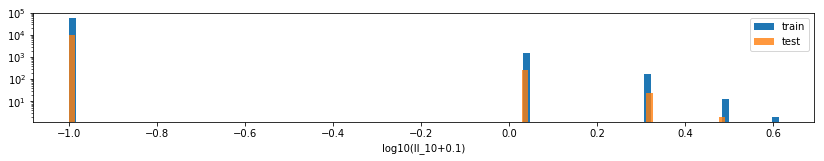

II_50 3.9079301 4.138642


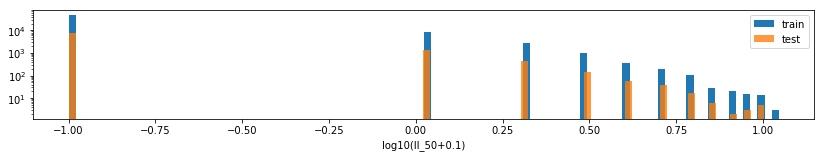

II_100 2.9132206 2.8873816


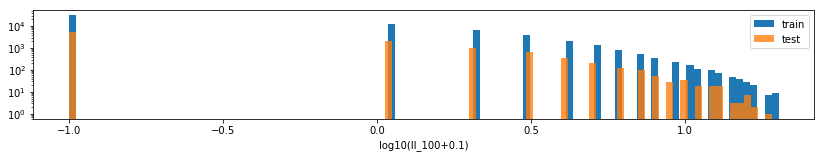

II_MIN 4.077665 4.0044827


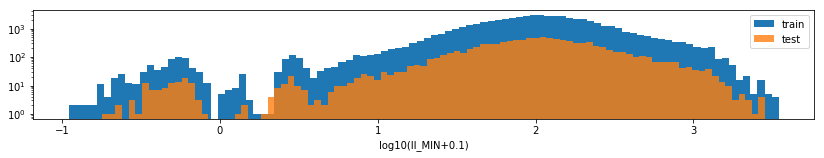

III_10 6.9982715 7.5043683


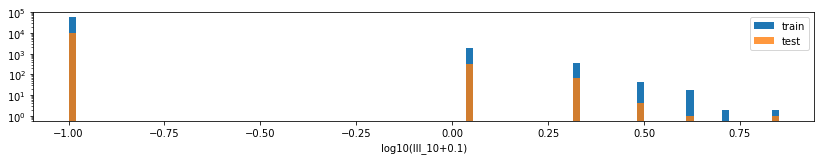

III_50 3.0506077 3.1624982


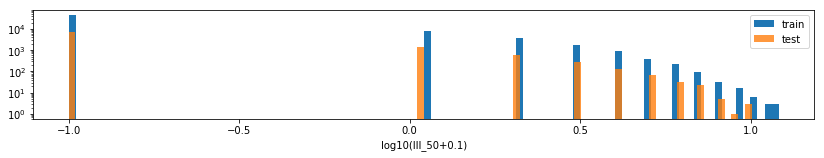

III_MIN 4.3727026 4.244612


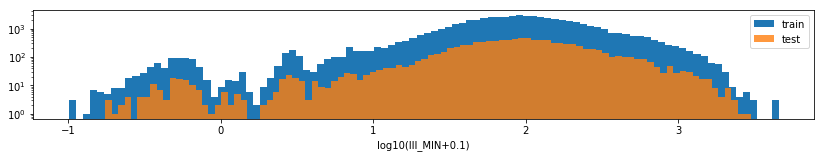

IV_10 17.977915 15.93509


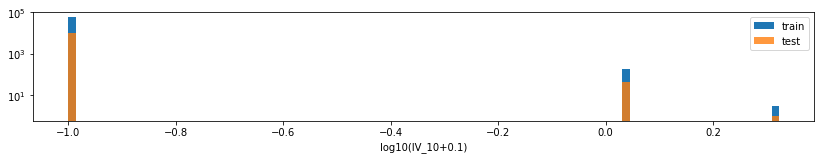

IV_50 10.386395 7.8387265


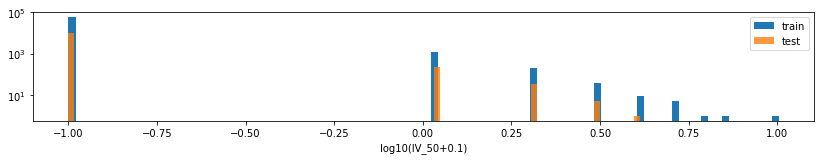

IV_100 8.617198 8.084886


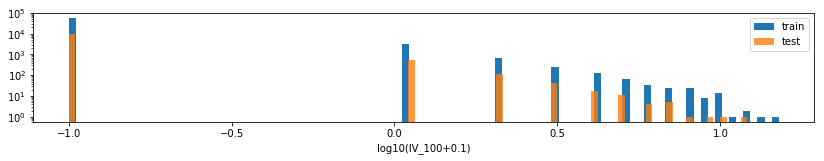

IV_250 7.7754474 7.9635


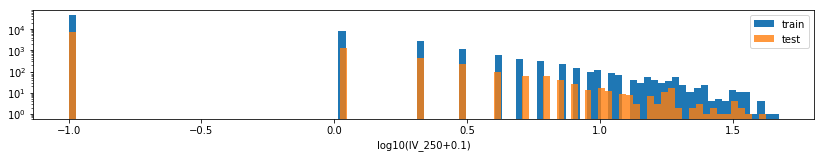

IV_500 6.389957 6.491073


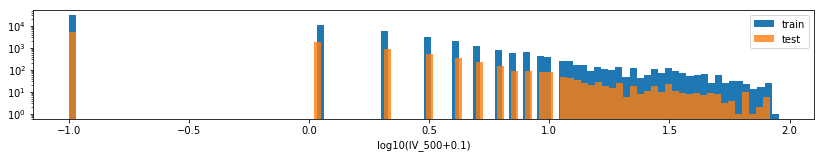

IV_1000 4.698029 4.8118544


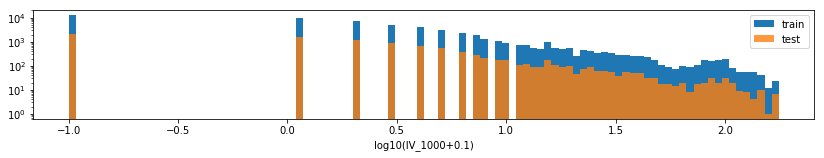

IV_MIN 2.4282353 2.5011384


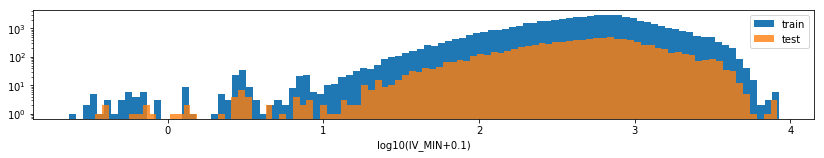

V_10 8.827745 8.486857


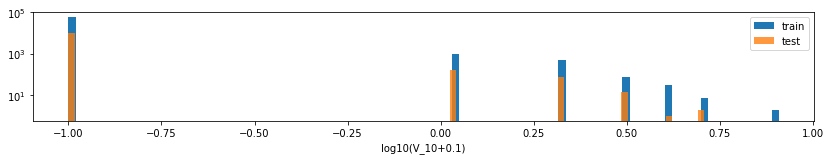

V_50 4.2386923 4.173547


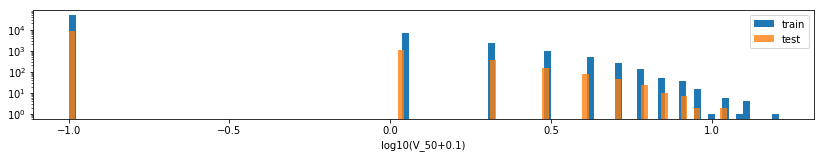

V_100 2.9428067 3.0030558


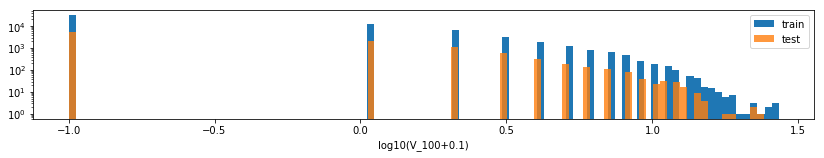

V_250 2.3122835 2.2262082


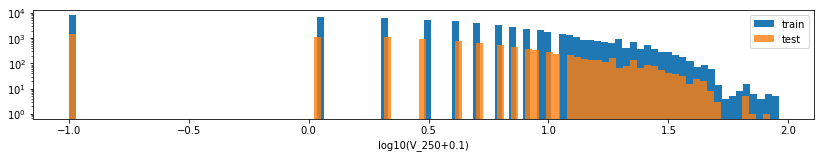

V_MIN 5.753089 5.292202


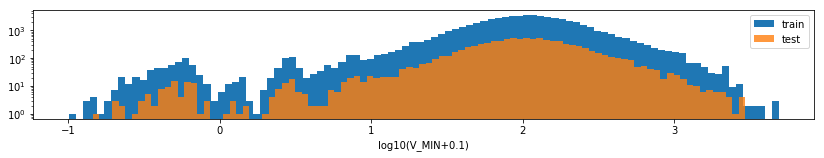

VI_50 7.9816914 7.6733685


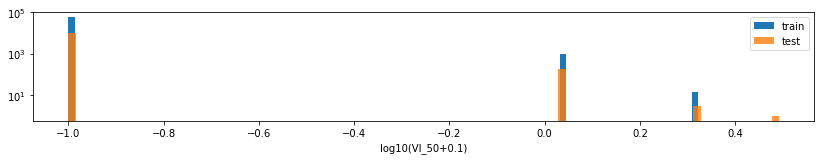

VI_100 4.481978 4.3473926


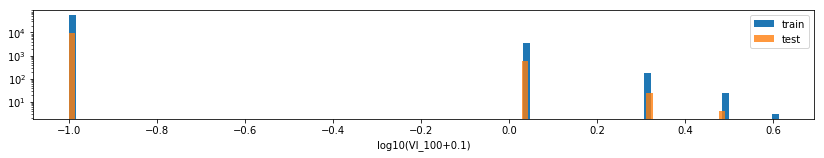

VI_250 3.3660257 3.1789112


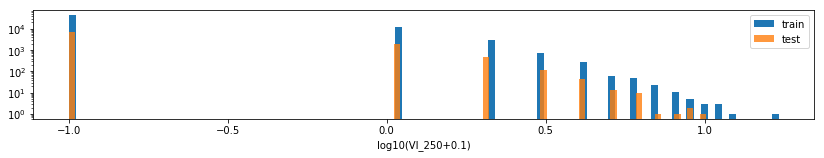

VI_500 3.9736202 4.098012


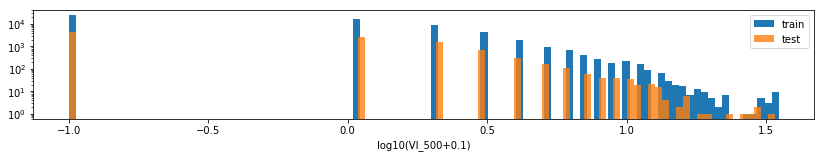

VI_1000 3.7657459 3.7933645


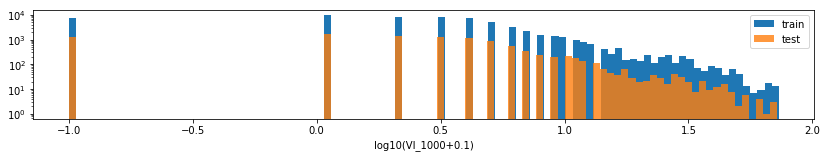

VI_MIN 2.2578814 2.1437562


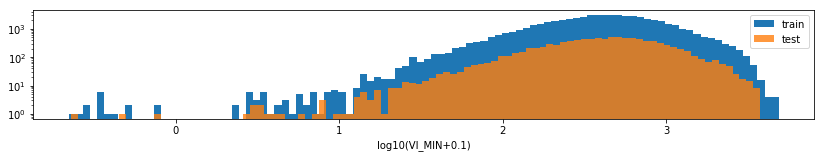

VII_10 5.941517 6.276888


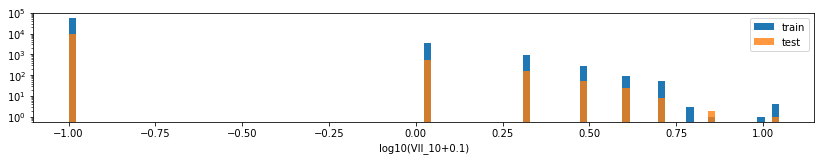

VII_50 3.9886582 4.071352


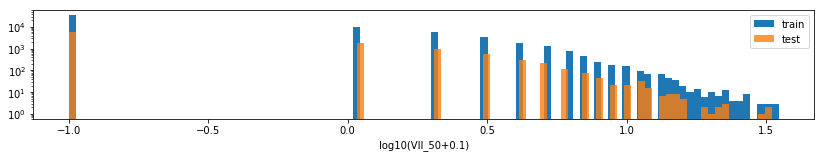

VII_100 4.1016526 4.4358816


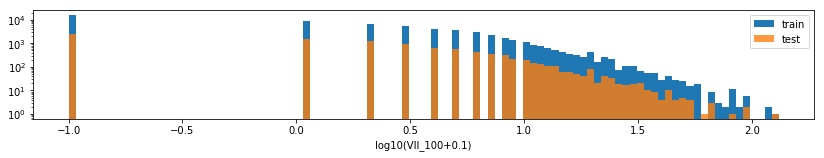

VII_250 3.6328163 3.7643542


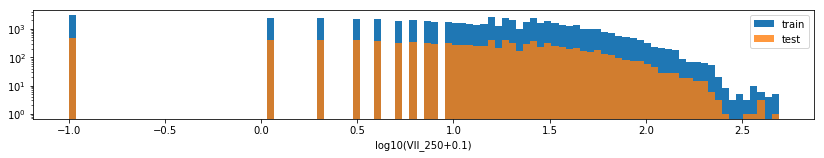

VII_500 2.77274 2.8113174


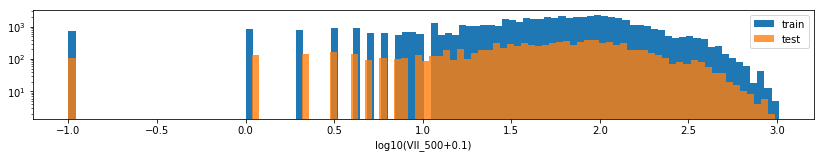

VII_1000 2.438202 2.4526136


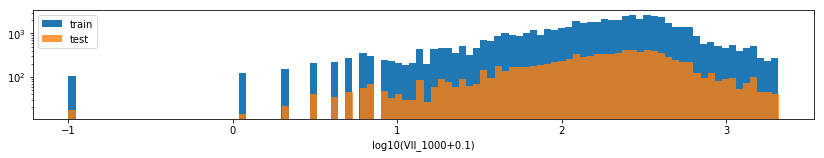

VII_MIN 4.6321354 4.531532


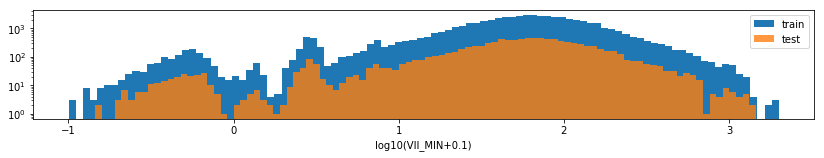

VIII_10 9.726184 8.548316


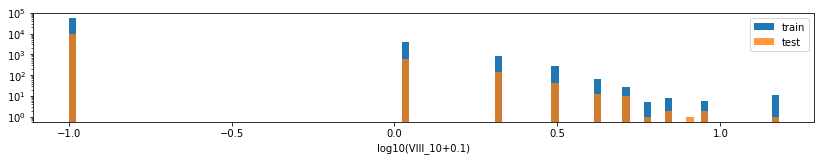

VIII_50 10.752237 15.427014


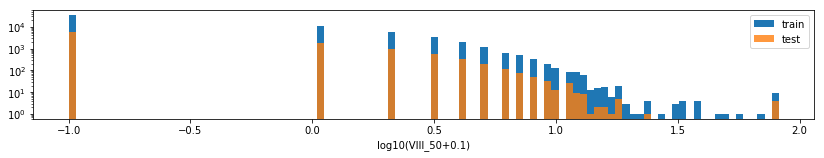

VIII_100 5.0303516 5.6050525


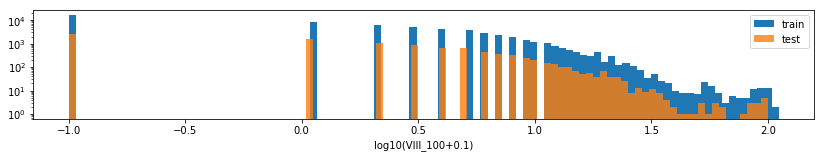

VIII_250 2.3620713 2.4382257


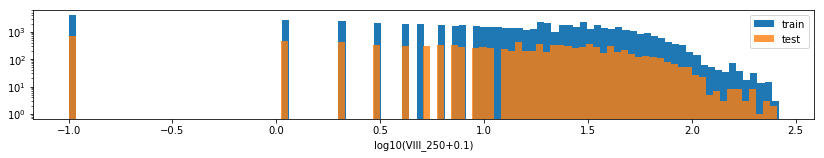

VIII_MIN 8.002373 7.093248


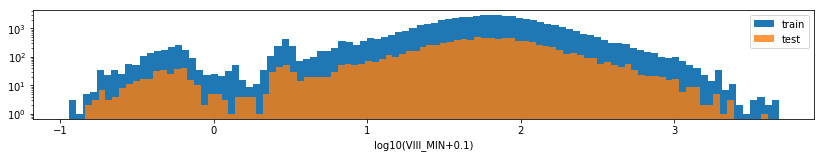

IX_10 7.972574 7.5448728


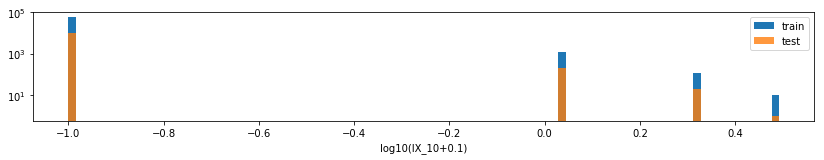

IX_50 4.423249 4.8351626


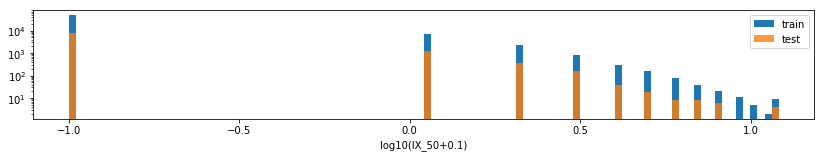

IX_100 3.3713365 3.3695827


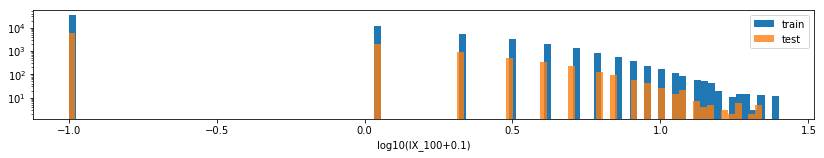

IX_250 2.5531566 2.7911084


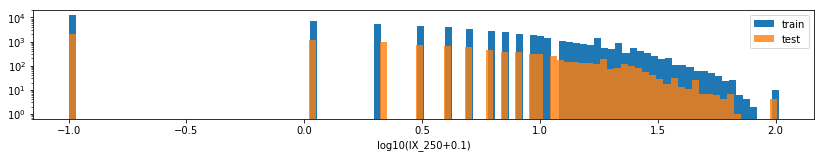

IX_MIN 5.401486 5.5396028


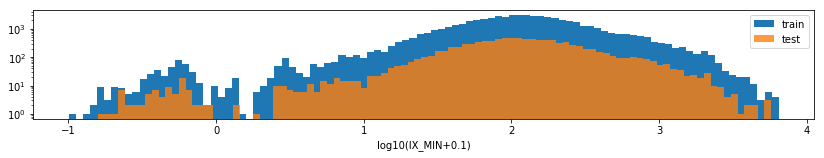

X_10 17.327974 15.78842


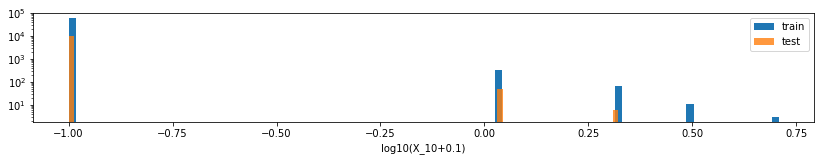

X_50 4.7664347 4.7560296


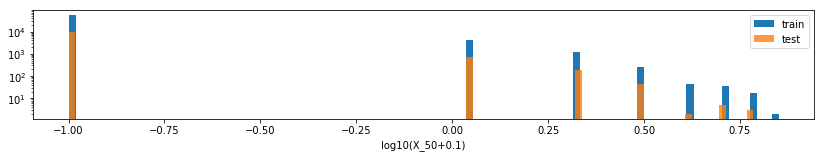

X_100 2.640059 2.697393


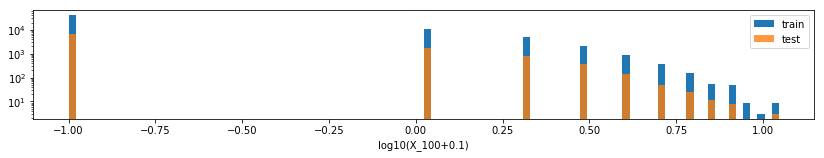

X_MIN 4.719582 4.951804


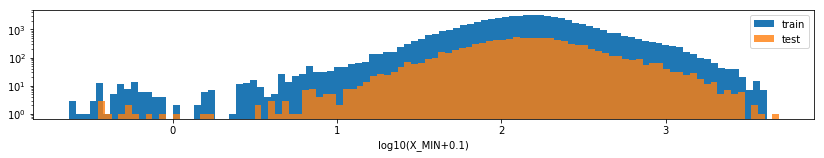

XI_10 14.460102 14.673334


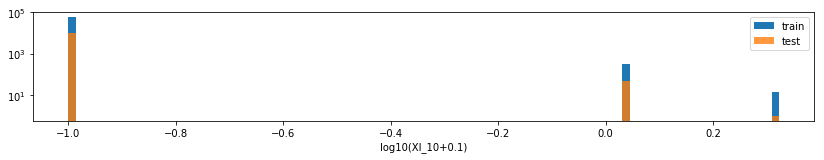

XI_50 3.9838955 3.904616


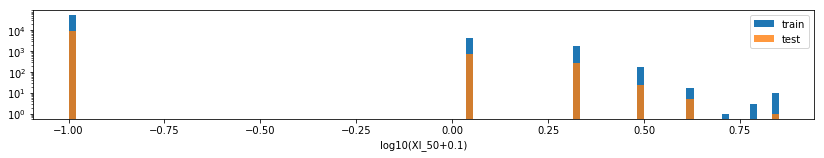

XI_MIN 7.0882425 6.3676124


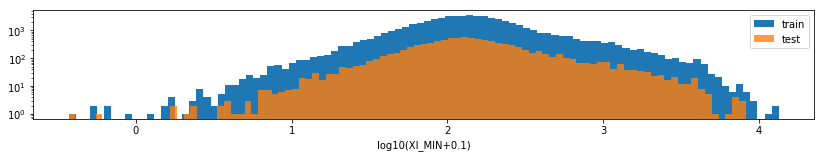

XII_10 3.9807894 3.7384255


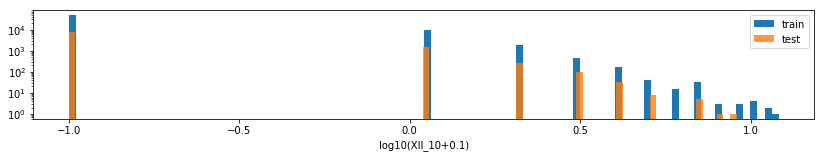

XII_50 4.328934 5.8791304


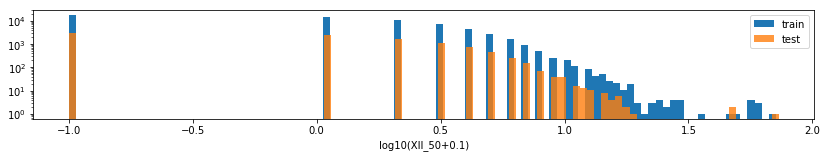

XII_100 2.8269734 3.6223187


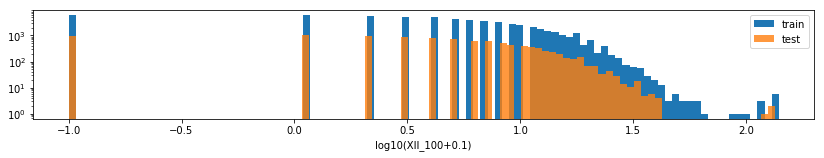

XII_MIN 7.2301226 10.799455


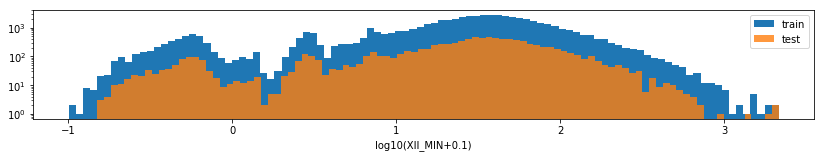

XIII_10 27.698206 26.186111


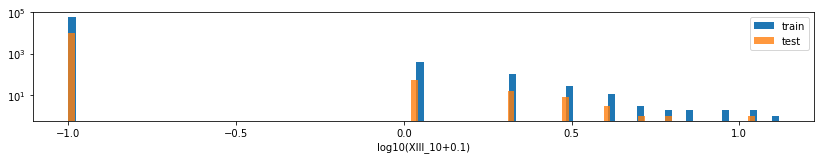

XIII_50 18.247444 19.435673


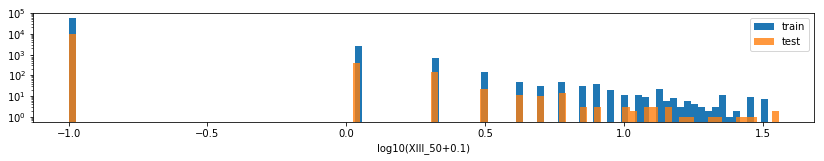

XIII_100 16.26816 17.205807


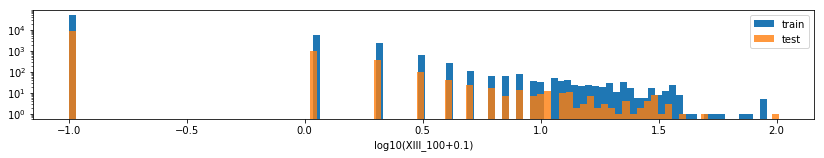

XIII_250 11.758964 13.603116


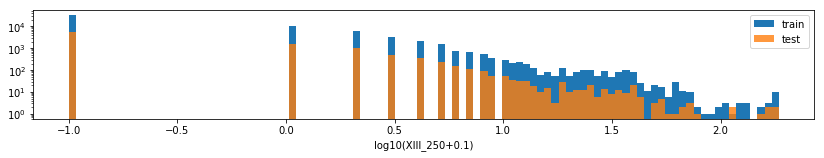

XIII_500 6.4615135 6.3016777


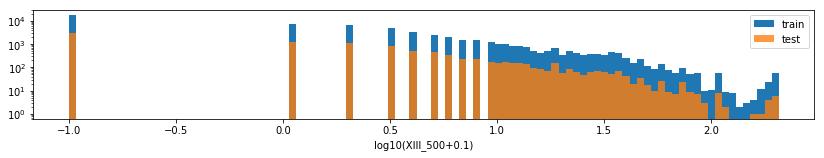

XIII_1000 2.453587 2.411887


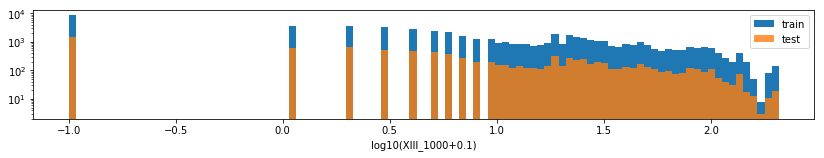

XIII_MIN 7.6069636 7.358621


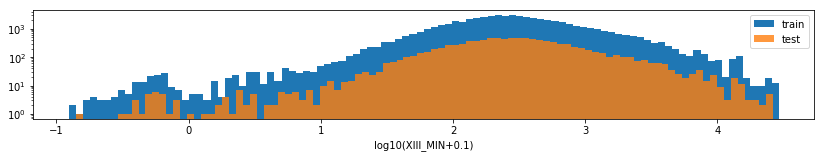

XIV_10 8.467 9.742323


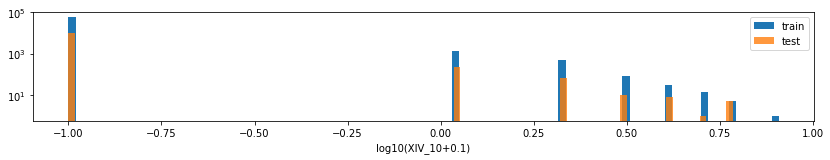

XIV_50 9.9951105 8.240139


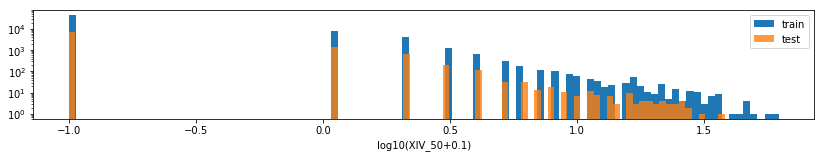

XIV_100 9.850256 9.700843


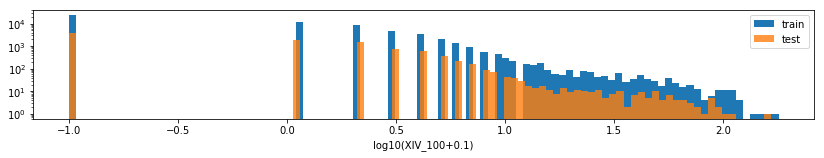

XIV_250 7.352517 7.7152786


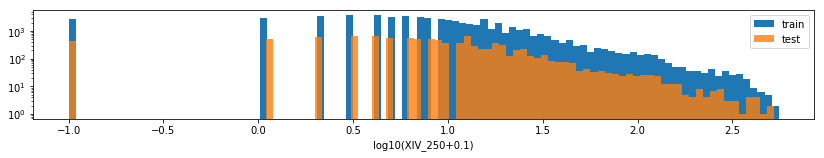

XIV_500 5.094125 5.1999984


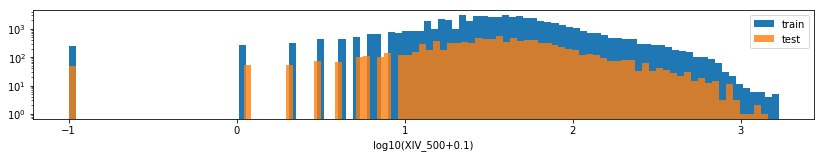

XIV_1000 3.6360552 3.7791774


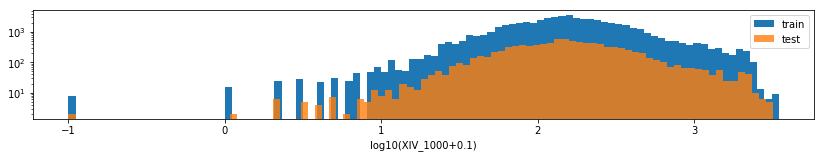

XIV_MIN 2.680964 2.7985368


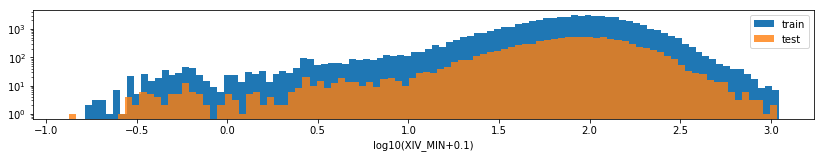

land_per_building_area 19.513025 10.554946


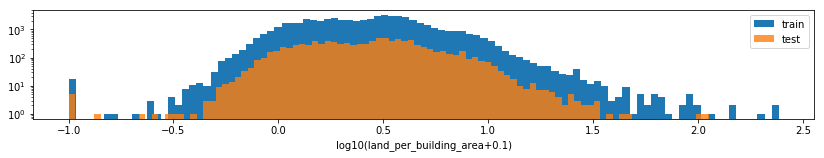

In [19]:
# skew check
for c in cols_right_skew:
    sq = train[c].astype('float32')
    sq2 = test[c].astype('float32')
    print(c, sq.skew(), sq2.skew())
    plt.figure(figsize=(14, 2))
    sq = np.log10(sq[np.isfinite(sq)]+0.1)
    sq2 = np.log10(sq2[np.isfinite(sq2)]+0.1)
    plt.hist(sq, bins=100, label='train', alpha=1)
    plt.hist(sq2, bins=100, label='test', alpha=0.8)
    plt.legend(); plt.xlabel('log10('+c+'+0.1)'); plt.yscale('log')
    plt.show()

In [20]:
for c in cols_right_skew:
    sq = test[c].astype('float32')
    print('% 21s'%c, '%6.3f'%sq.skew(), sq.min(), sq.max(), np.isfinite(sq).mean(), sq.isnull().mean())

         parking_area  7.871 0.0 103.89554 0.05 0.95
        parking_price  2.386 0.0 326960.9 0.229 0.771
            land_area 13.955 0.0 1634.7765 1.0 0.0
        building_area 68.804 0.49076244 3730.9832 1.0 0.0
village_income_median  2.758 442.0 1851.0 0.9816 0.0184
                 I_10 13.761 0.0 1.0 1.0 0.0
                 I_50  5.176 0.0 6.0 1.0 0.0
                I_100  2.952 0.0 8.0 1.0 0.0
                I_MIN  2.719 0.12266964 2057.1536 1.0 0.0
                II_10  6.783 0.0 3.0 1.0 0.0
                II_50  4.139 0.0 10.0 1.0 0.0
               II_100  2.887 0.0 19.0 1.0 0.0
               II_MIN  4.004 0.079155795 2849.4092 1.0 0.0
               III_10  7.504 0.0 7.0 1.0 0.0
               III_50  3.162 0.0 10.0 1.0 0.0
              III_MIN  4.245 0.07425927 2991.7544 1.0 0.0
                IV_10 15.935 0.0 2.0 1.0 0.0
                IV_50  7.839 0.0 4.0 1.0 0.0
               IV_100  8.085 0.0 12.0 1.0 0.0
               IV_250  7.964 0.0 42.0 1.0 0.0
        

#### VIllage and Town

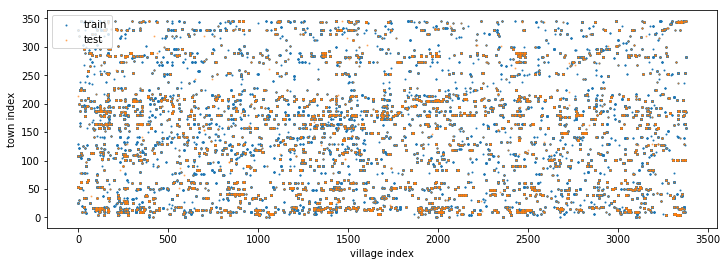

In [27]:
plt.figure(figsize=(12, 4))
plt.scatter(train['village'], train['town'], s=1, label='train')
plt.scatter(test['village'], test['town'], s=1, alpha=0.5, label='test')
plt.xlabel('village index'); plt.ylabel('town index'); plt.legend(); plt.show()

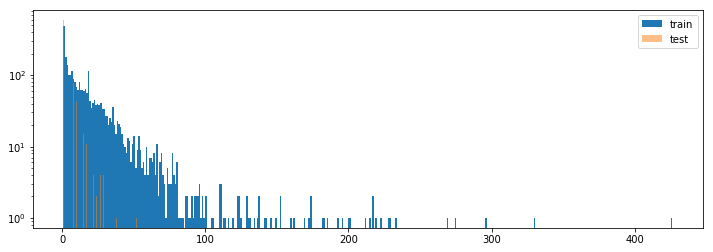

In [26]:
plt.figure(figsize=(12, 4))
bins
plt.hist(train['village'].value_counts(), bins=400, label='train')
plt.hist(test['village'].value_counts(), bins=400, label='test', alpha=0.5)
plt.yscale('log'); plt.legend(); plt.show()

In [37]:
train_village_counts = train['village'].value_counts()
village_train_1 = train_village_counts.index[train_village_counts == 1]

In [1]:
#print(set(train['village'].unique()) - set(test['village'].unique()))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


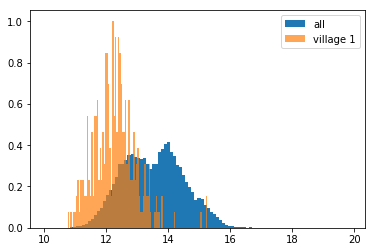

In [45]:
plt.hist(train[col_target], label='all', bins=100, normed=True)
plt.hist(train.loc[train['village'].isin(set(village_train_1)), col_target], label='village 1', alpha=0.7, bins=100, normed=True)
plt.legend(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


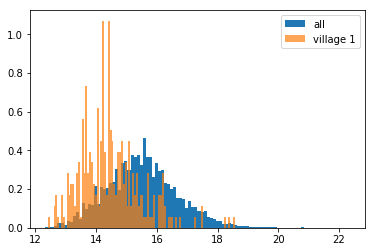

In [47]:
plt.hist(train['log_total_price'], label='all', bins=100, normed=True)
plt.hist(train.loc[train['village'].isin(set(village_train_1)), 'log_total_price'], label='village 1', alpha=0.7, bins=100, normed=True)
plt.legend(); plt.show()

In [34]:
village_test_1 = set(test['village'].unique()) - set(train['village'].unique())
print(village_test_1)

{2052, 651, 907, 788, 2068, 2836, 2586, 1437, 2590, 1059, 2725, 2342, 3109, 424, 2730, 2219, 2348, 1966, 562, 564, 438, 950, 1465, 700, 2429, 1343, 831, 1347, 2244, 2884, 70, 1606, 2760, 590, 210, 3158, 2780, 1120, 353, 1504, 3179, 364, 3189, 1016, 250, 2812, 1021, 2943}


In [2]:
#test.loc[test['village'].isin(village_test_1), 'village'].value_counts()

In [74]:
set(test['town']) - set(train['town'])

{51, 319}

In [12]:
print(set(train['town']) - set(test['town']))

{131, 7, 8, 141, 143, 23, 280, 31, 40, 300, 46, 175, 307, 182, 59, 316, 63, 64, 195, 325, 198, 327, 205, 335, 90, 94, 222, 223, 103, 232, 234, 107, 240, 243, 248, 250, 255}


In [76]:
test.loc[test['town'].isin(set(test['town']) - set(train['town'])), 'town'].value_counts()

51     1
319    1
Name: town, dtype: int64

In [91]:
train_town_counts = train['town'].value_counts()
set(train_town_counts.index[train_town_counts == 1]) - set(test['town'])

{59, 223, 232, 255, 300}

In [88]:
train_village_counts = train['village'].value_counts()

In [90]:
len(set(train_village_counts.index[train_village_counts == 1])), len(set(train_village_counts.index[train_village_counts == 1]) - set(test['village']))

(288, 233)

In [80]:
test['town'].value_counts().tail(10)

238    1
283    1
263    1
271    1
146    1
186    1
261    1
166    1
89     1
161    1
Name: town, dtype: int64

### Feature engineering
Include cat encoding, fillna, scaling

In [13]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding
from feature_engineering import PdStandardScaler, PdMedianScaler, PdMinMaxScaler

In [14]:
class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_bin, col_target, 
                 fillna_values={}, cols_right_skew=[], is_embedding=False, is_tar_encoded=True,
                 n_ran_encode=4, rare_village_threshold=1, rare_town_threshold=1):
        # Cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_bin = cols_bin
        self.col_target = col_target
        self.cols_right_skew = cols_right_skew
        
        # Numbers
        #self.n_ran_encode = n_ran_encode
        
        # Cat encoders
        self.is_tar_encoded = is_tar_encoded
        if is_tar_encoded:
            self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.is_embedding = is_embedding
        if is_embedding:
            self.cat_astyper = CategoricalColumnsEncoder(mode='keras', reserve_missing=True)
        
        # Fillna
        self.fillna_values = fillna_values
        
        # Skewness
        self.mins_right_skew_cols = {}  # map from the col name to the original min
        
        # Normalization
        self.scaler = PdStandardScaler()
        
        # Target normalization
        self.target_scaler = PdStandardScaler()
        
        # Rare village and town threshold
        self.rare_village_threshold = rare_village_threshold
        self.rare_town_threshold = rare_town_threshold
        
    def fit_transform(self, df, df_test):
        df = df.copy()
        
        # Rare village and town
        train_towns = df['town'].value_counts()
        rare_towns = (set(train_towns.index[train_towns <= self.rare_town_threshold])
                      - set(df_test['town']))
        df.loc[df['town'].isin(rare_towns), 'town'] = np.nan
        
        train_villages = df['village'].value_counts()        
        rare_villages = (set(train_villages.index[train_villages <= self.rare_village_threshold])
                         - set(df_test['village']))
        df.loc[df['village'].isin(rare_villages), 'village'] = np.nan        
        
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
            self.cols_tar_encoded = [c for c in df_tar_encoded]
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        else:
            self.cols_tar_encoded = []
        #encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        if self.is_embedding:
            self.cat_astyper.fit_transform(df, self.cols_cat)
        
        # Fillna
        self.fillna_values['village_income_median'] = df['village_income_median'].median()
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)
    
        # Skewness
        for c in self.cols_right_skew:
            # if the minimum of the col < 0, then subtract the min first (to make it positive)
            self.mins_right_skew_cols[c] = min(df[c].min(), 0)
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
    
        # Normalization
        self.scaler.fit(df, cols=self.cols_num+self.cols_tar_encoded)
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        assert self.col_target in df, 'Target column not found in the dataframe'
        self.target_scaler.fit(df, cols=[self.col_target])
        self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.transform(df[self.cols_cat])
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        #encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        if self.is_embedding:
            self.cat_astyper.transform(df)
    
        # Fillna
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)    

        # Skewness
        for c in self.cols_right_skew:
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
        
        # Normalization
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        if self.col_target in df:
            self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
        
    def target_inverse_transform(self, df, col_scaled_target, col_unscaled_target):
        self.target_scaler.inverse_transform(df, cols_input=[col_scaled_target], 
                                             cols_transformed=[col_unscaled_target])
        return df[col_unscaled_target]

#### Debug

In [15]:
# for debug only
feat_eng_t = FeatureEngineering(
    cols_num, cols_cat, cols_bin, col_target, fillna_values, cols_right_skew, 
    is_embedding=is_embedding, is_tar_encoded=is_tar_encoded,
)

In [17]:
dfp2 = feat_eng_t.fit_transform(train, test)

In [18]:
df_test_2 = feat_eng_t.transform(test)

In [19]:
for c in cols_cat:
    print(c, dfp2[c].min(), df_test_2[c].min())

building_material 1 1
city 1 1
building_type 1 1
building_use 1 1
parking_way 1 1
town 0 0
village 0 0
encoded_latlon 1 1


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 253 entries, building_id to land_per_building_area
dtypes: float32(212), int32(8), int64(10), object(23)
memory usage: 65.5+ MB


In [21]:
dfp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 254 entries, building_id to log_per_area_total_price_scaled
dtypes: float32(213), int16(2), int64(10), int8(6), object(23)
memory usage: 64.4+ MB


In [22]:
dfp2['building_area_ori'].check()

0         3.418175
1         4.041309
2         5.584279
3        13.563030
4         4.688108
59995     6.754059
59996     5.356788
59997     8.223644
59998     8.728287
59999     5.356788
Name: building_area_ori, dtype: float32

shape = (60000,)


In [23]:
dfp2.loc[:, cols_right_skew].check()

,parking_area,parking_price,land_area,building_area,village_income_median,I_10,I_50,I_100,I_MIN,II_10,...,XIII_1000,XIII_MIN,XIV_10,XIV_50,XIV_100,XIV_250,XIV_500,XIV_1000,XIV_MIN,land_per_building_area
0,-0.231141,-0.548478,-0.034321,-1.083755,-0.832583,-0.065183,-0.263001,1.703675,-0.832046,-0.171635,...,0.145465,-0.749270,-0.180916,1.286209,0.868860,0.785981,0.462953,-0.006479,-0.815420,1.077574
1,-0.231141,-0.548478,-0.585236,-0.850874,-1.054259,-0.065183,-0.263001,1.703675,-0.821228,-0.171635,...,0.378751,-1.739329,-0.180916,1.286209,0.259084,-0.011966,-0.217229,-0.333009,-0.653663,0.146355
2,-0.231141,-0.548478,0.162689,-0.398604,-0.331743,-0.065183,-0.263001,1.703675,-0.861084,-0.171635,...,0.766046,-0.398741,-0.180916,-0.568642,0.639647,0.969325,0.739957,0.308603,-0.324044,0.598467
3,-0.231141,1.949962,-0.585236,0.853831,2.034907,-0.065183,-0.263001,-0.544676,1.450282,-0.171635,...,-1.986968,1.164134,-0.180916,-0.568642,0.259084,-0.904404,-0.530962,-0.245559,0.325351,-1.563488
4,-0.231141,-0.548478,1.410950,-0.643622,-1.199987,-0.065183,-0.263001,-0.544676,1.476255,-0.171635,...,-1.986968,1.440665,-0.180916,-0.568642,-1.152160,-0.904404,-0.629102,-1.270909,0.561897,2.421389
59995,-0.231141,-0.548478,1.190228,-0.131352,-0.638337,-0.065183,-0.263001,-0.544676,0.909380,-0.171635,...,-0.823375,0.891123,-0.180916,-0.568642,-1.152160,-0.254354,-1.272990,-1.145050,0.731163,1.598644
59996,3.912365,2.041708,-1.760647,-0.456933,0.622895,-0.065183,-0.263001,1.703675,-1.076028,-0.171635,...,1.117989,-1.999798,-0.180916,2.611255,1.356574,1.021490,0.852773,0.727418,-1.464716,-1.661464
59997,-0.231141,1.899042,-0.585236,0.146071,-0.277742,-0.065183,-0.263001,-0.544676,-0.444238,-0.171635,...,0.674563,0.063775,-0.180916,-0.568642,0.259084,0.540864,1.086681,0.828638,0.271905,-0.873087
59998,-0.231141,-0.548478,0.249229,0.230130,0.086478,-0.065183,3.735125,1.703675,-1.818665,-0.171635,...,0.632523,-1.414836,-0.180916,2.087661,1.033406,-0.011966,-0.400700,-0.111814,-0.858804,0.051958
59999,-0.231141,-0.548478,-0.148090,-0.456933,-0.006669,-0.065183,-0.263001,1.703675,-1.144050,-0.171635,...,0.766046,-0.394989,-0.180916,1.286209,0.639647,0.169854,0.703279,0.477385,-0.470801,0.274764


shape = (60000, 77)


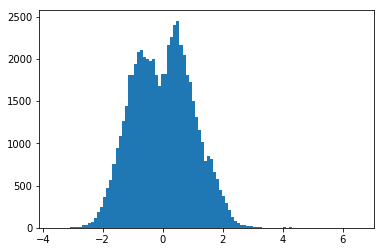

In [24]:
plt.hist(dfp2['log_per_area_total_price_scaled'], bins=100); plt.show()

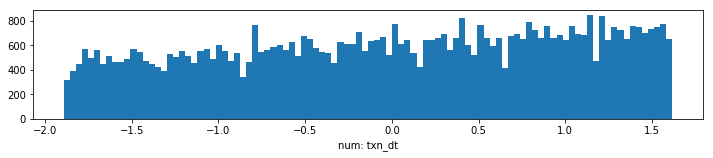

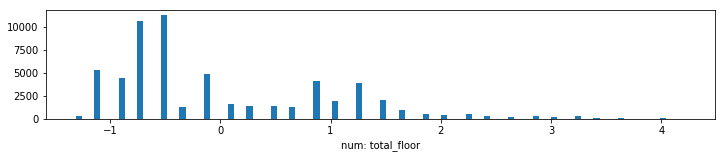

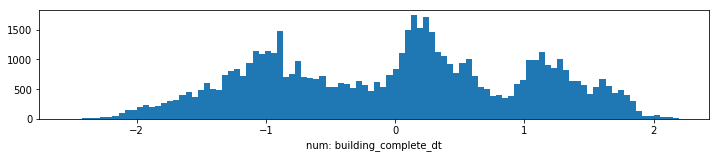

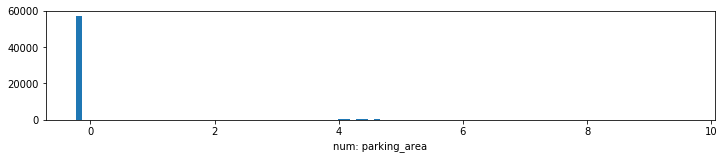

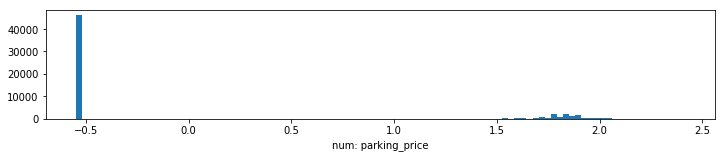

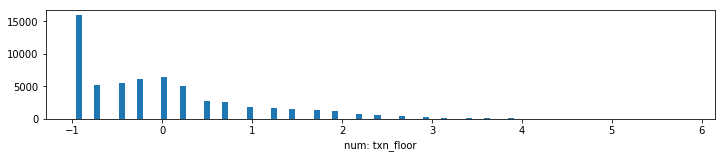

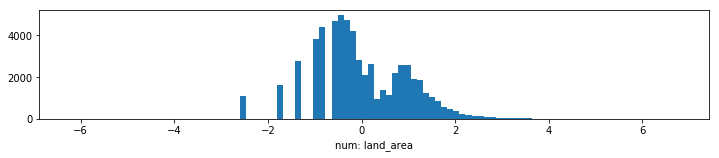

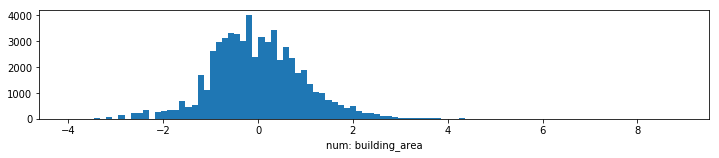

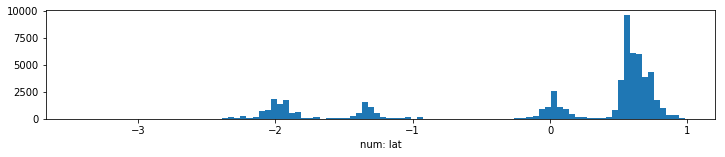

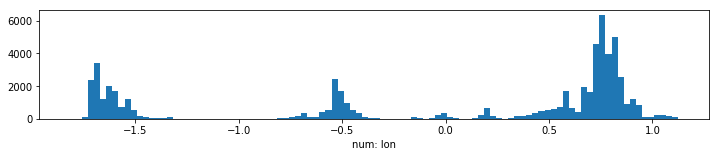

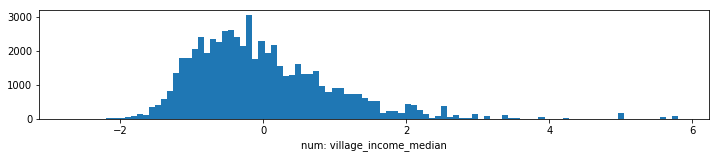

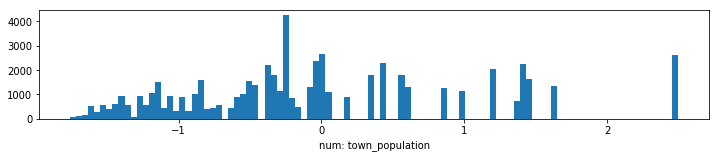

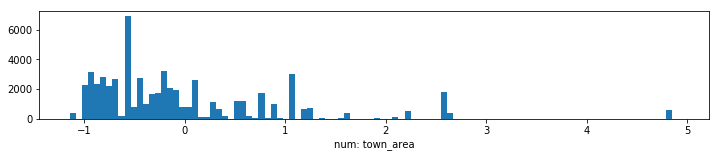

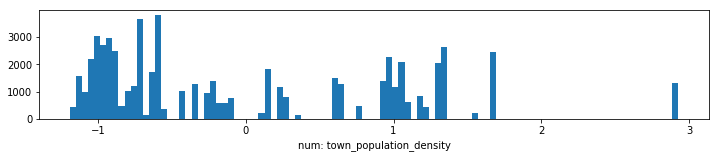

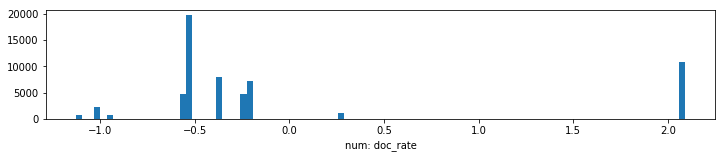

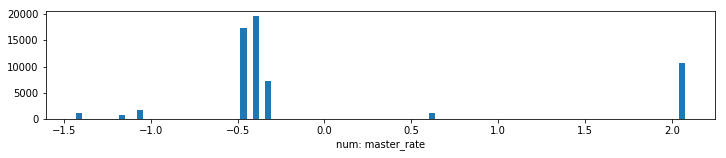

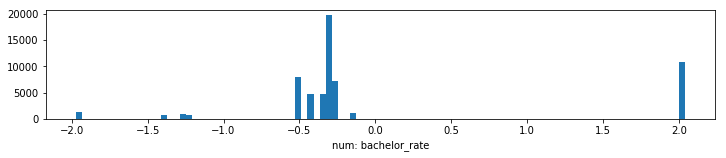

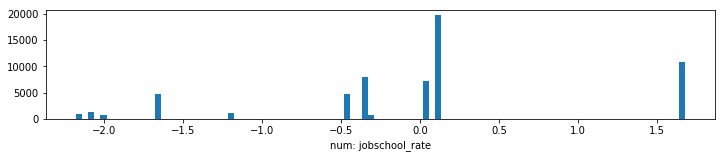

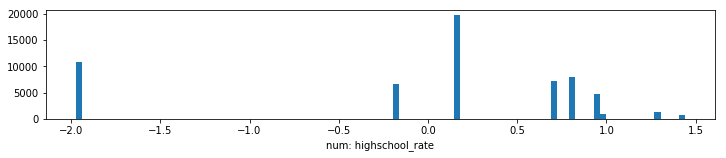

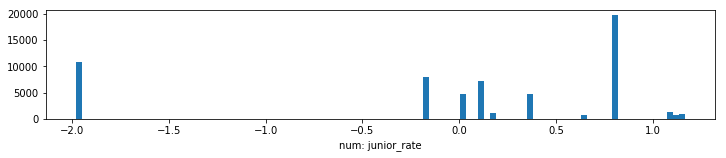

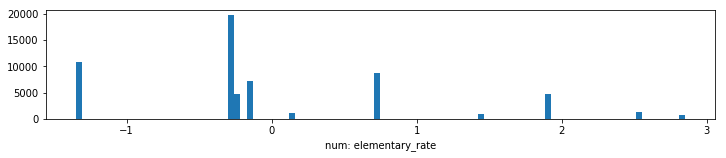

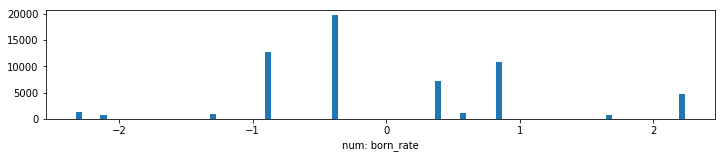

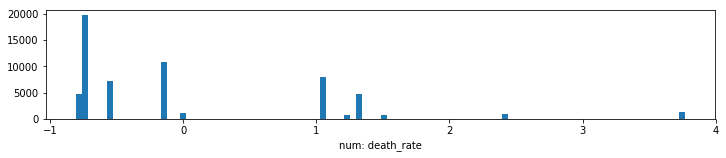

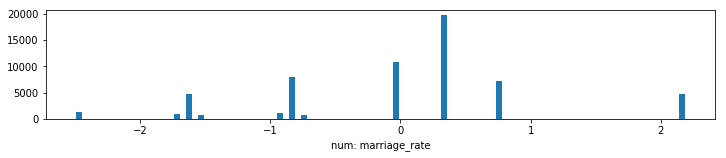

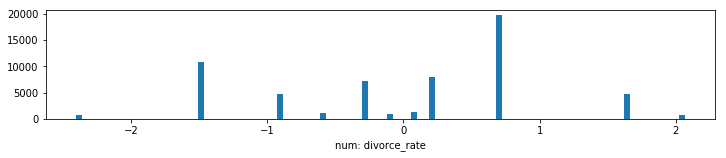

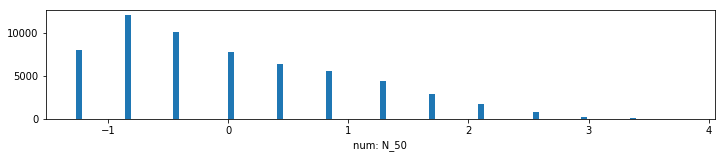

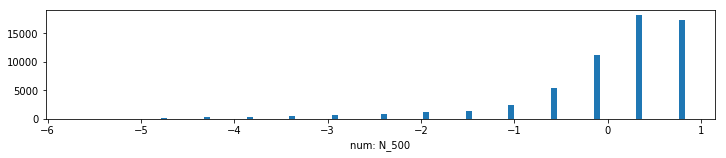

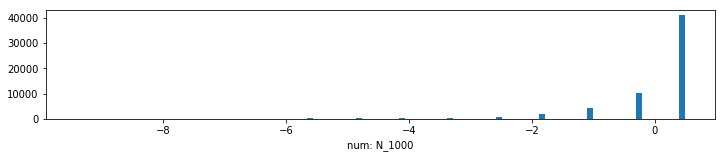

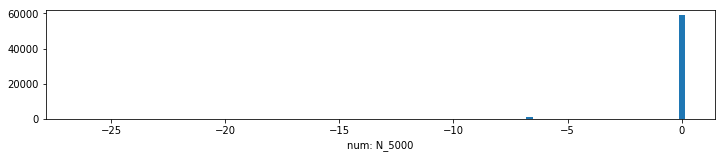

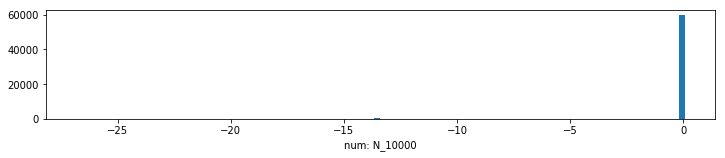

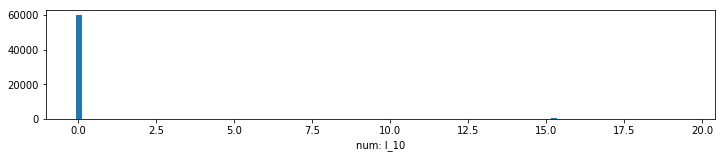

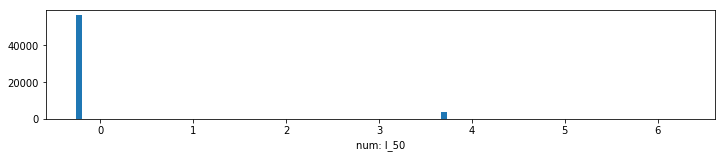

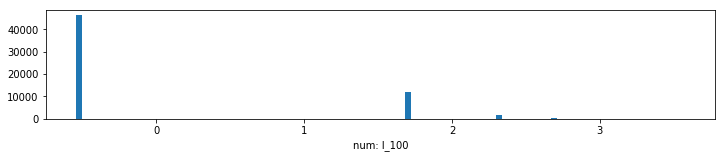

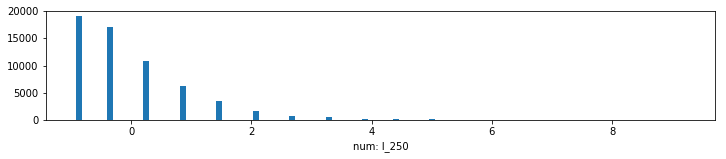

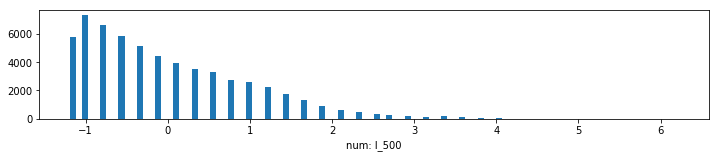

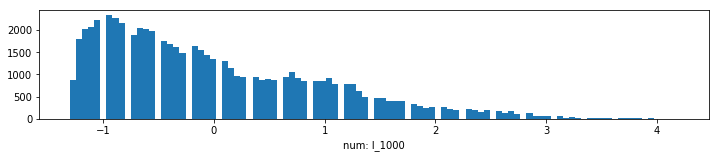

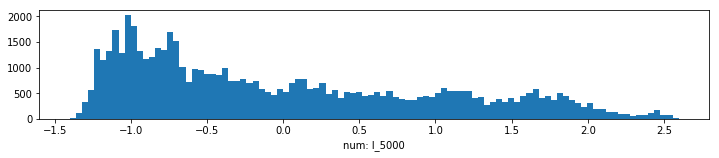

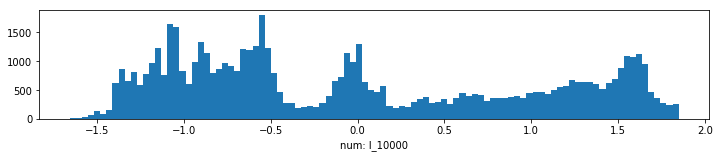

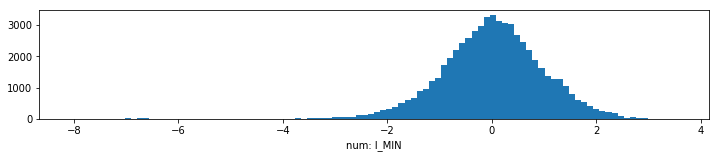

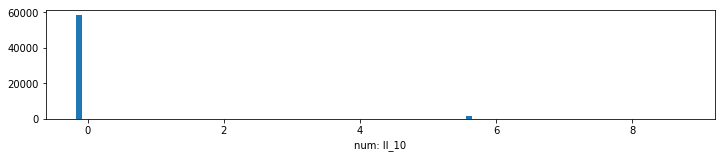

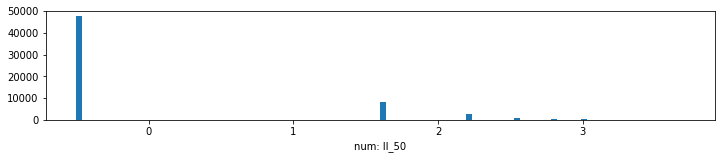

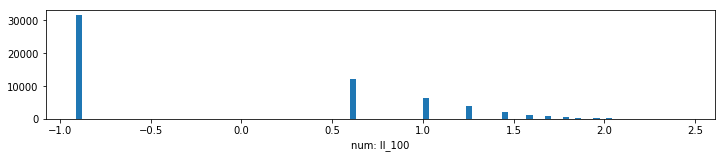

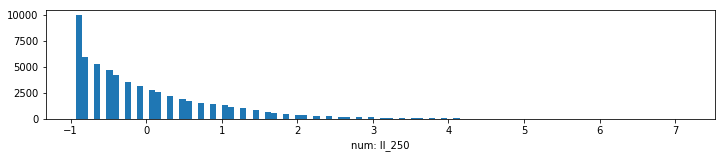

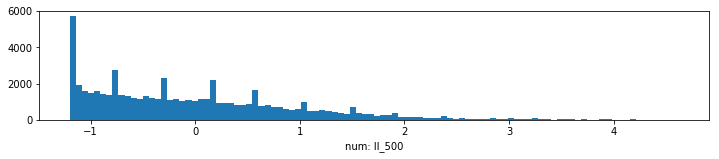

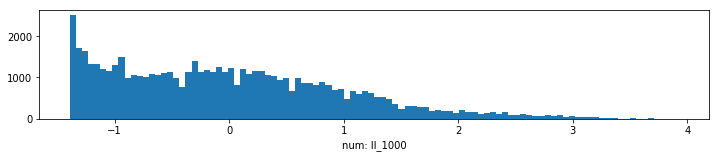

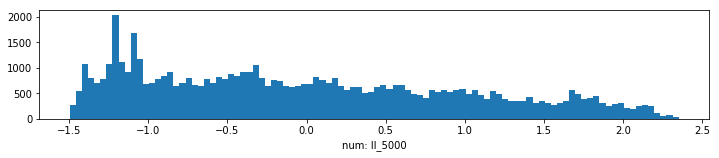

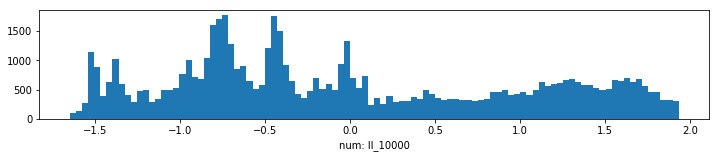

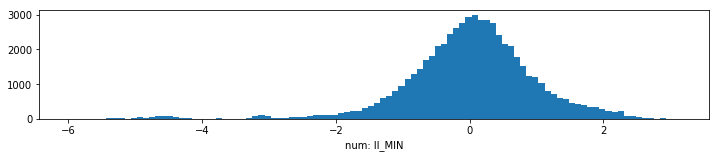

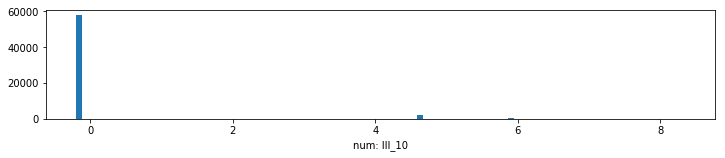

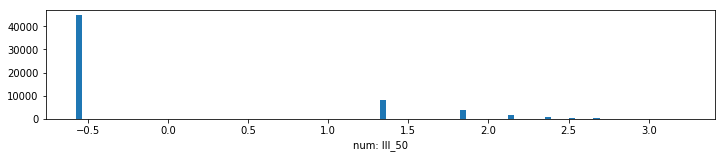

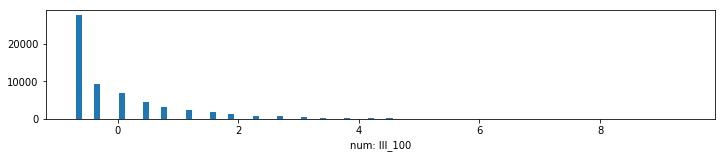

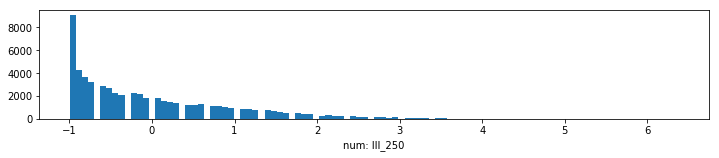

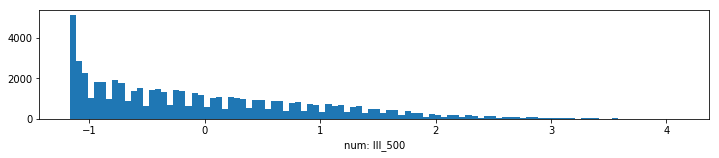

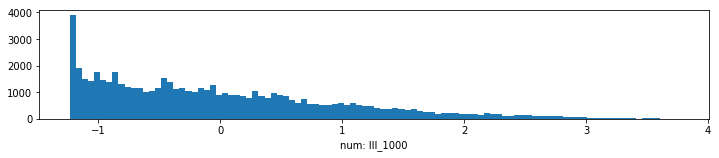

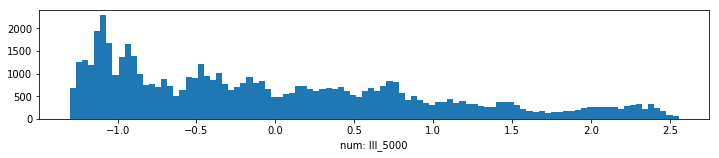

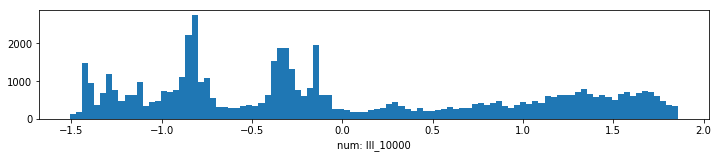

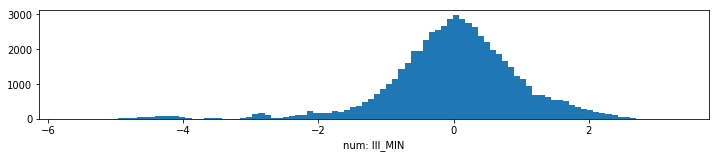

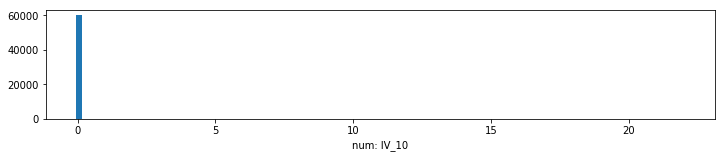

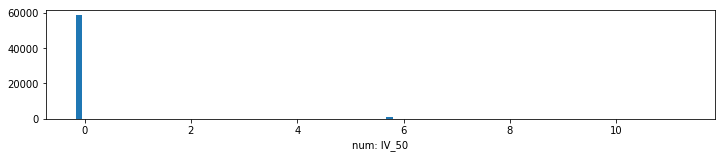

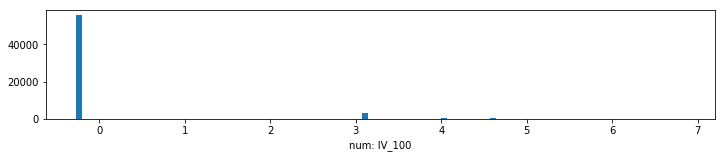

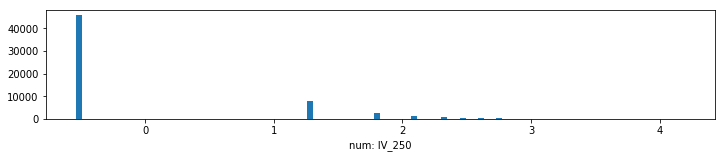

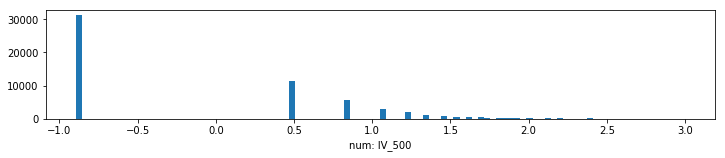

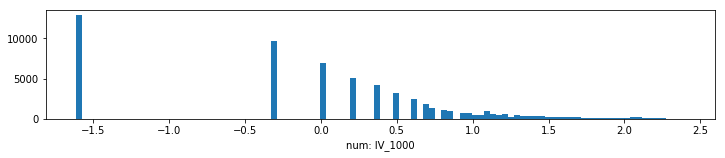

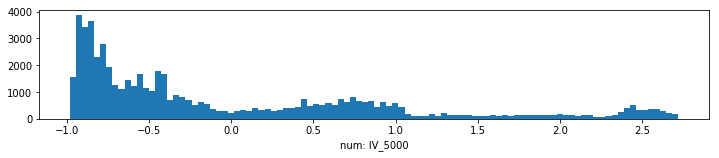

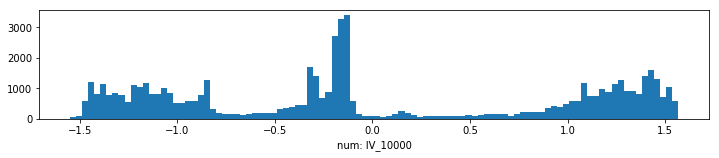

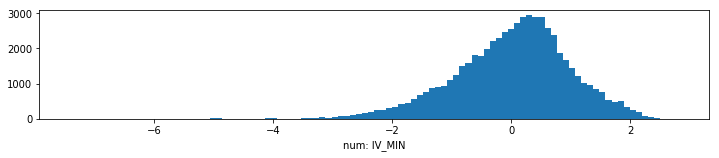

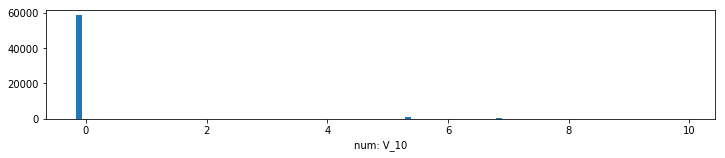

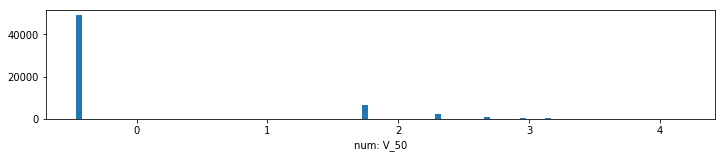

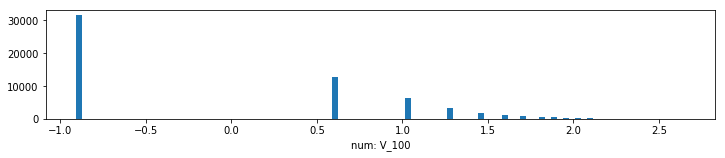

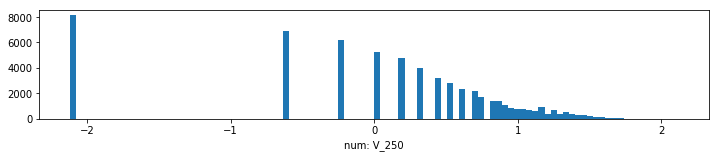

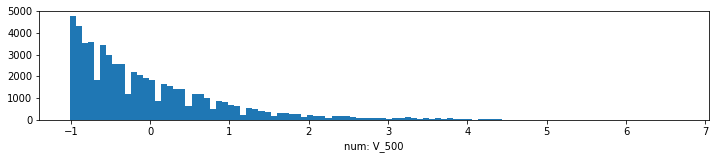

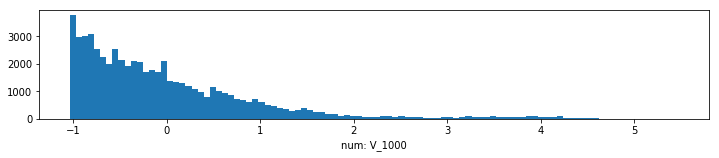

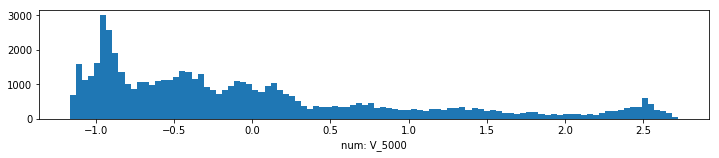

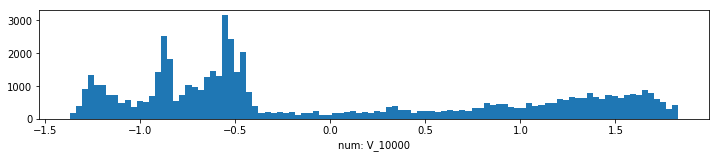

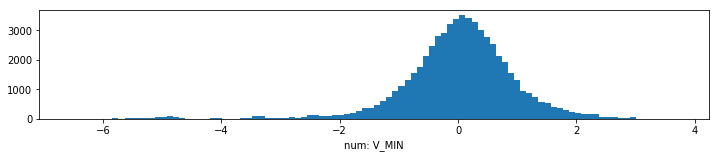

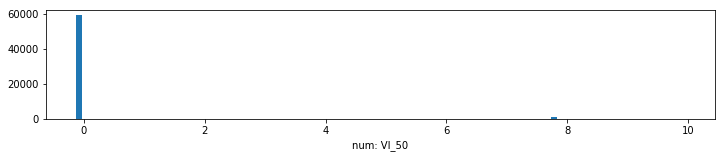

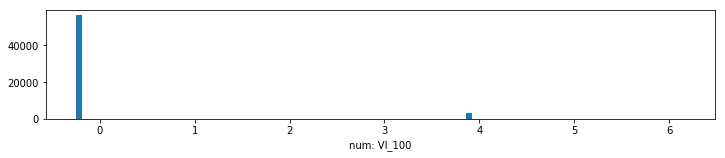

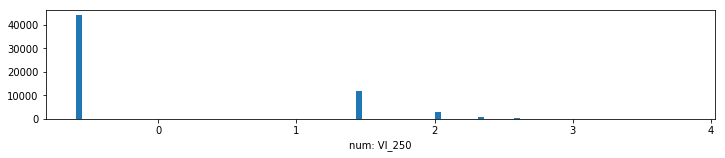

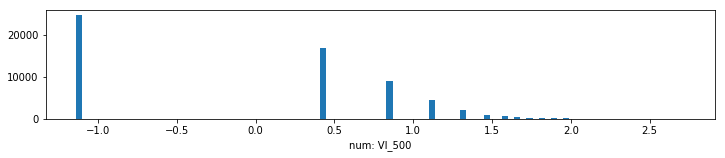

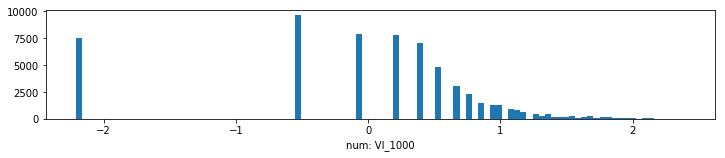

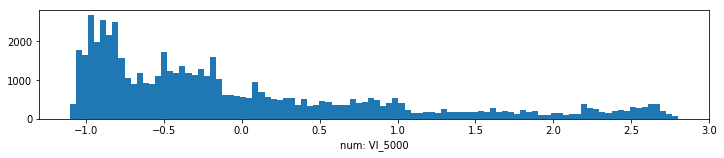

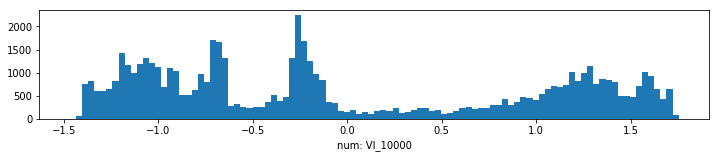

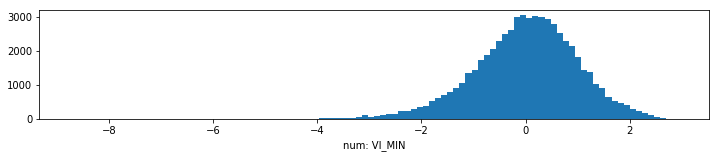

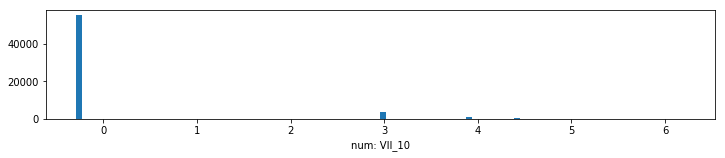

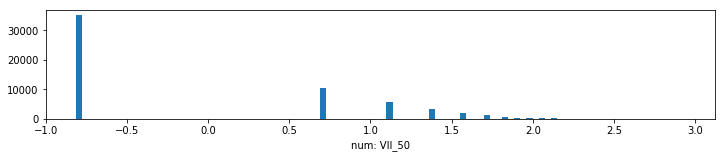

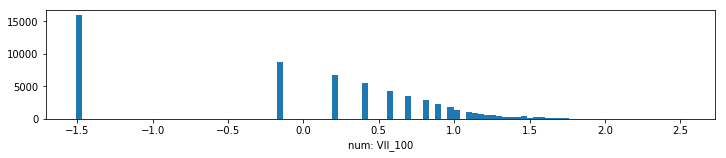

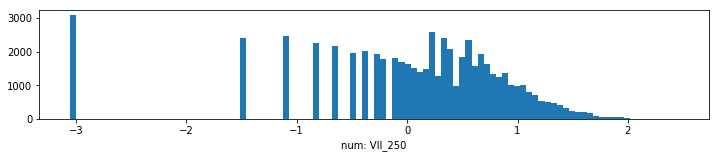

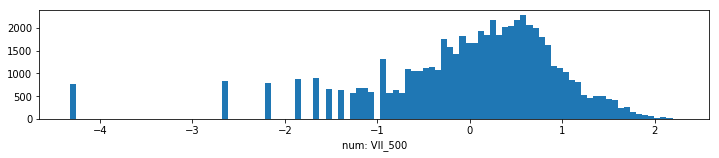

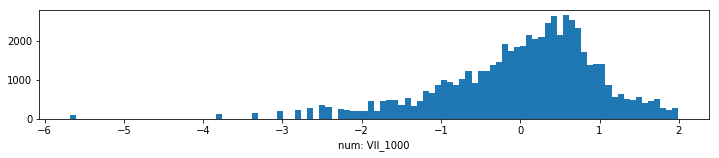

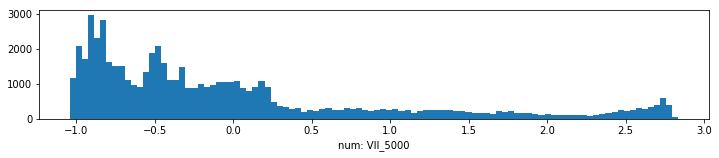

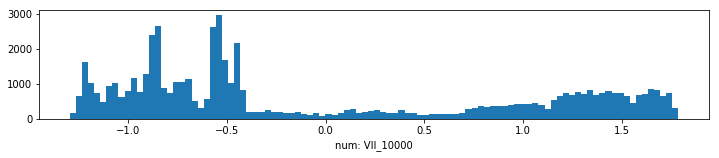

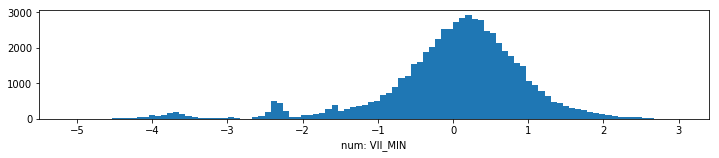

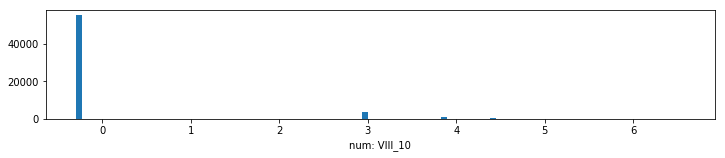

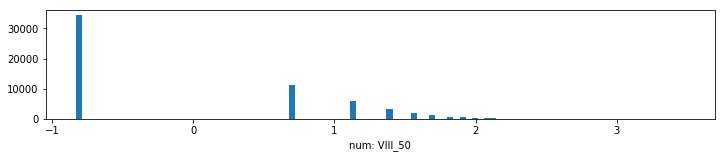

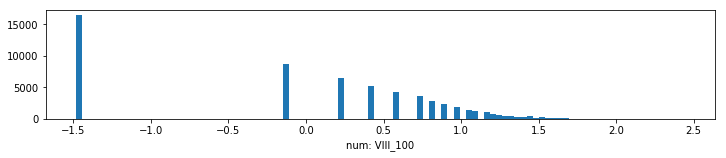

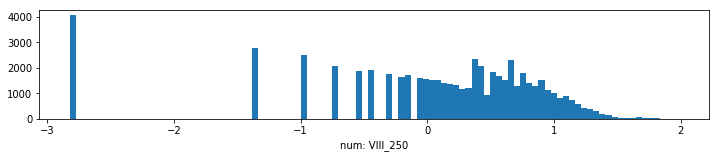

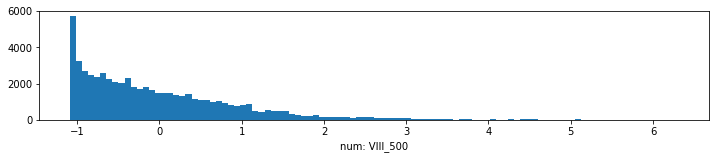

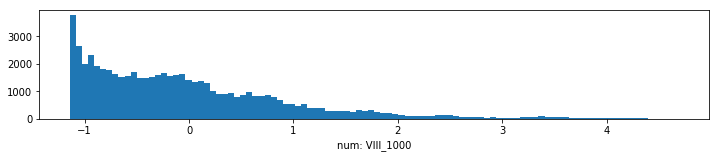

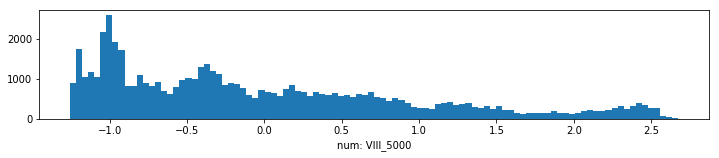

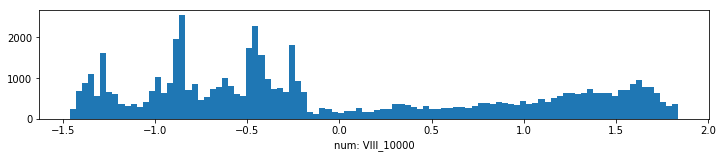

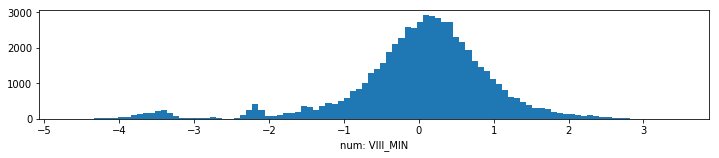

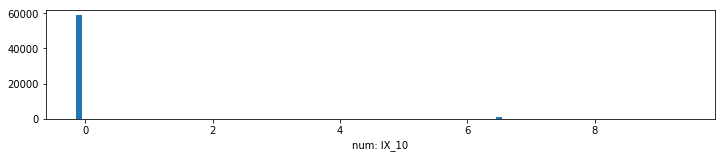

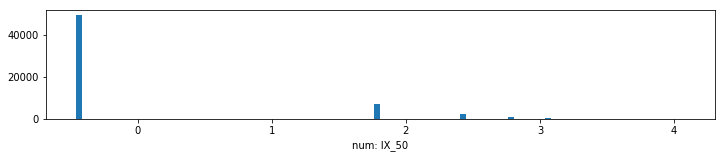

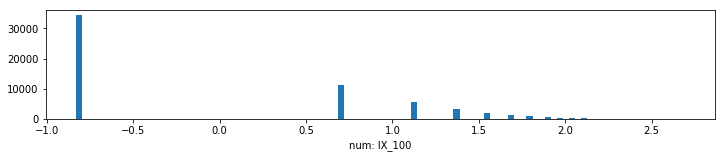

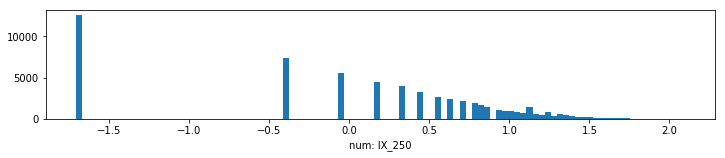

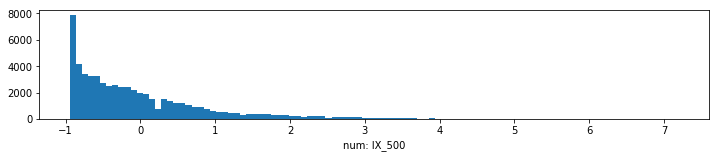

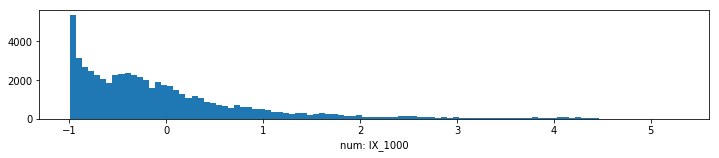

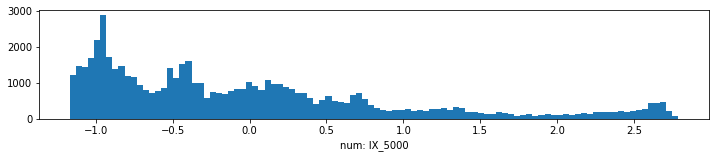

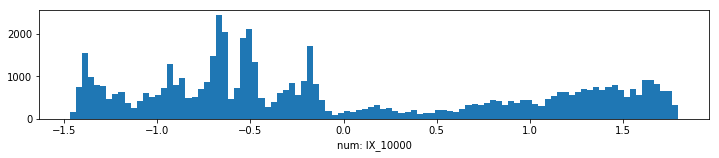

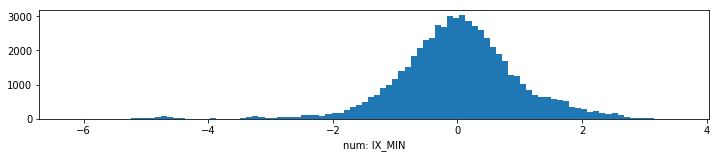

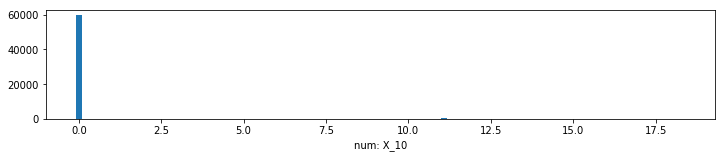

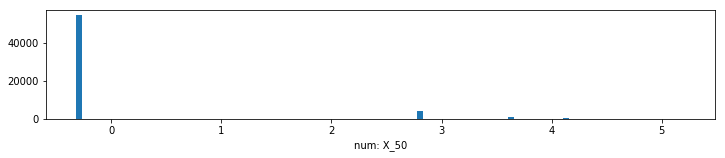

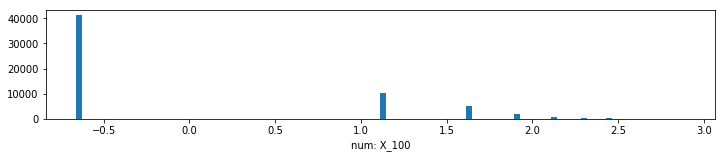

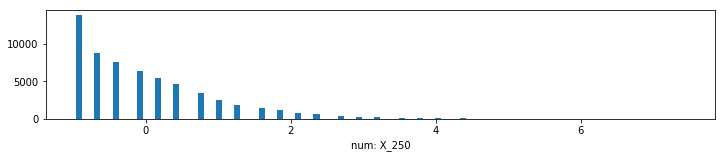

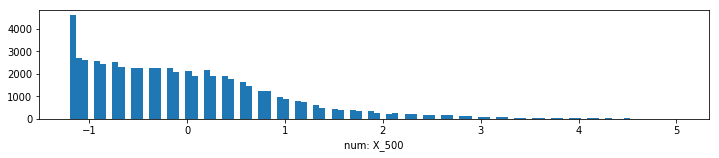

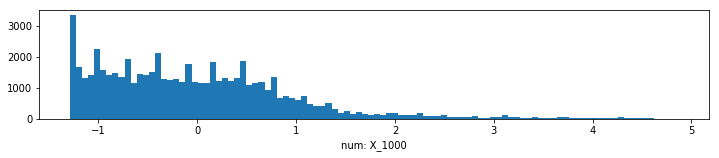

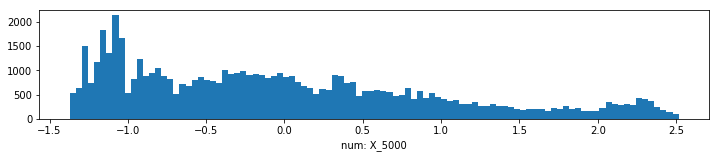

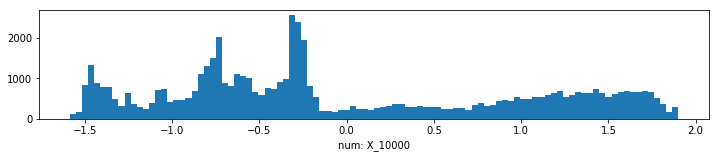

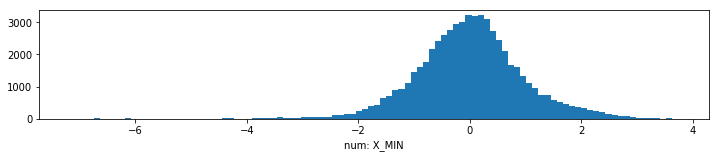

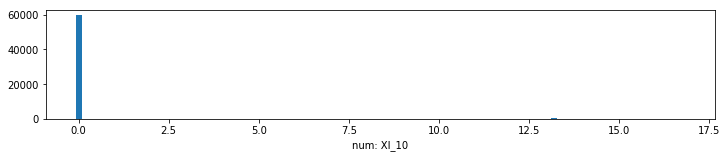

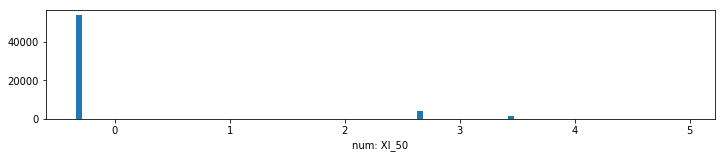

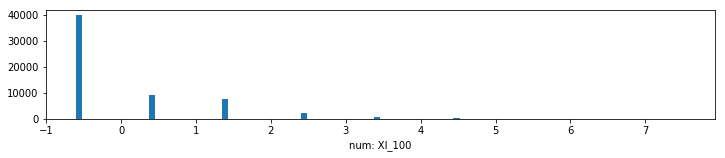

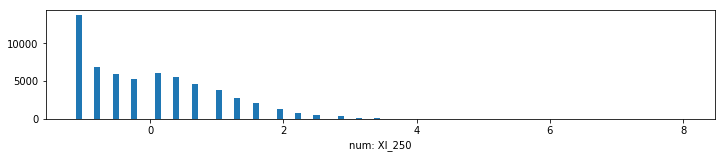

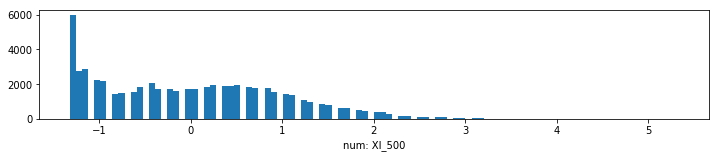

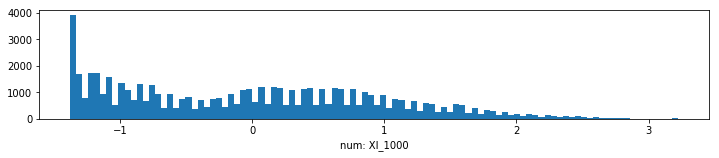

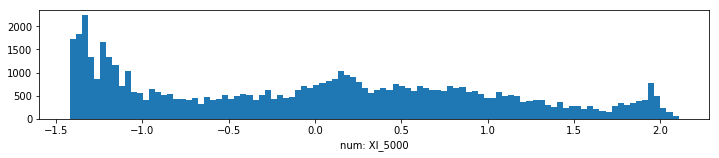

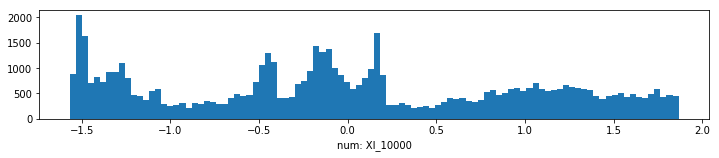

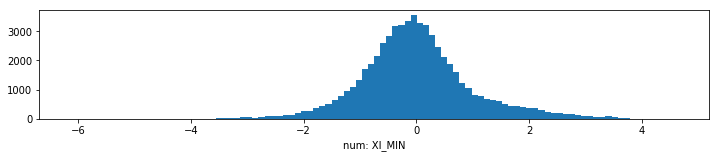

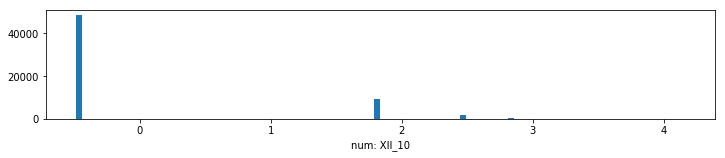

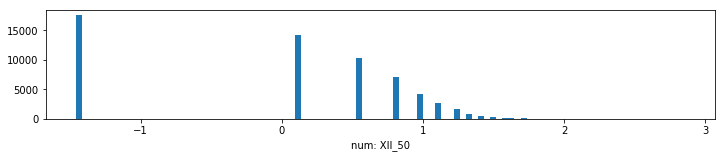

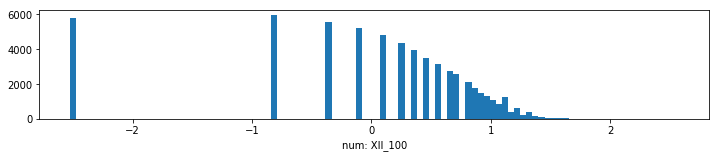

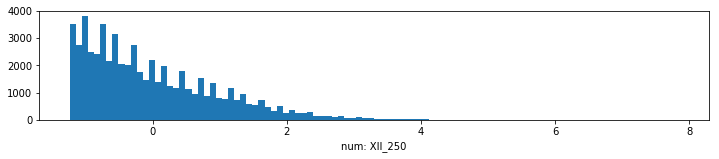

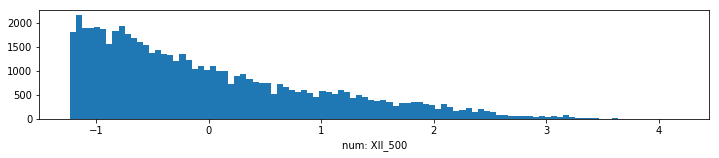

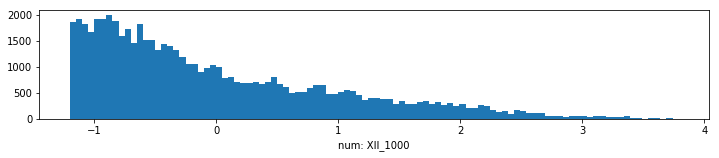

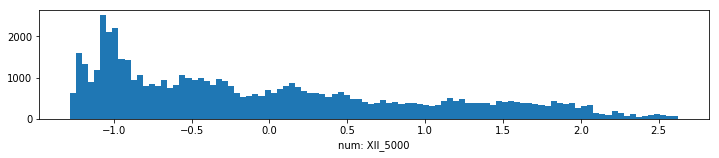

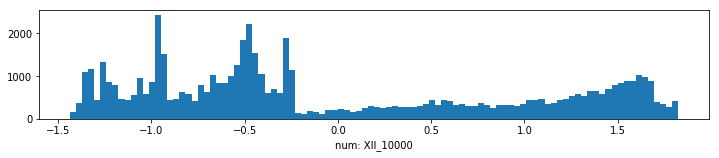

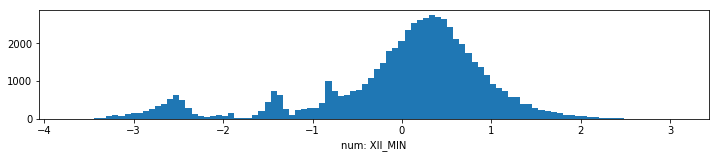

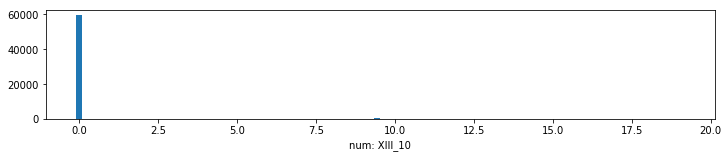

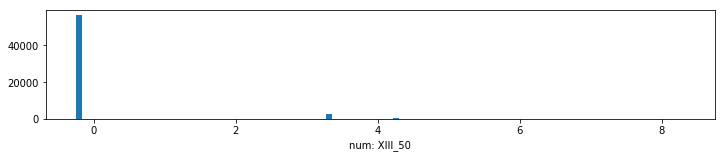

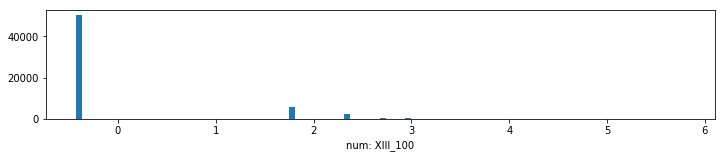

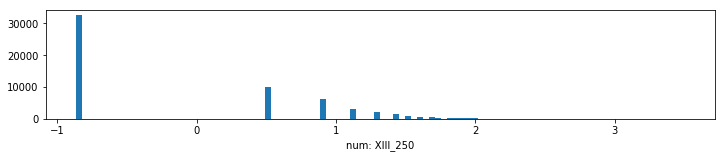

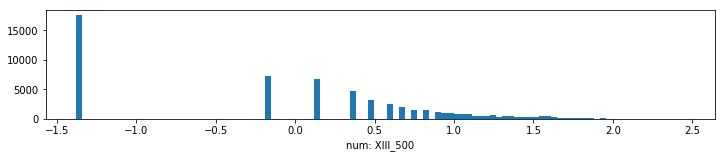

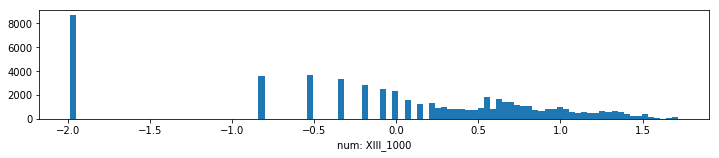

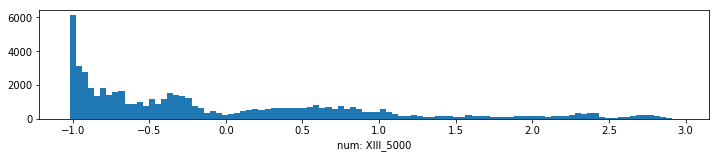

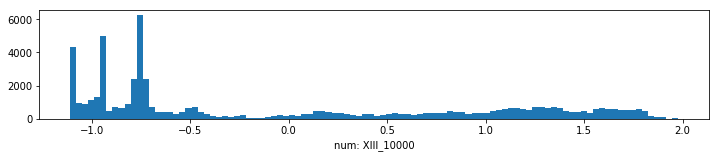

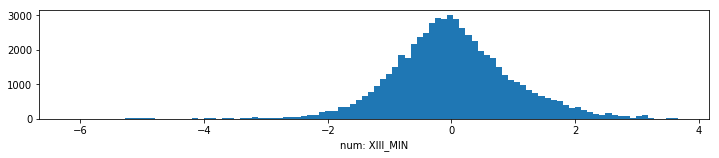

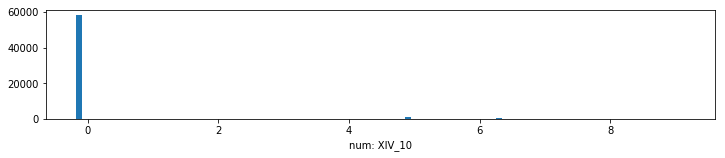

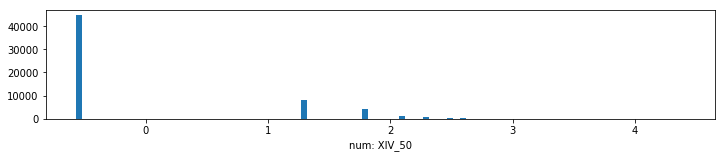

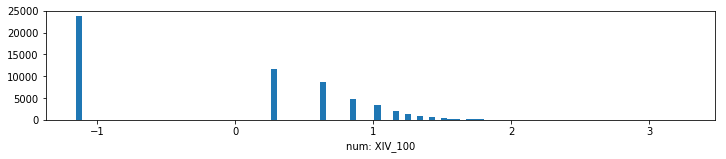

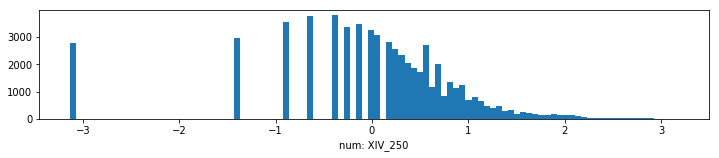

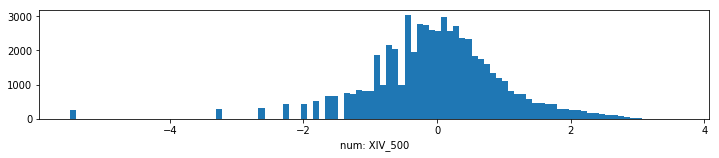

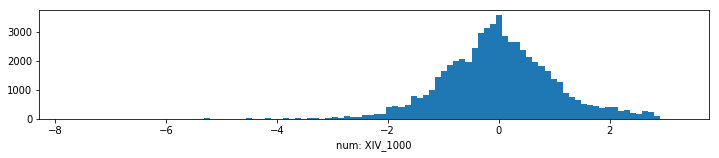

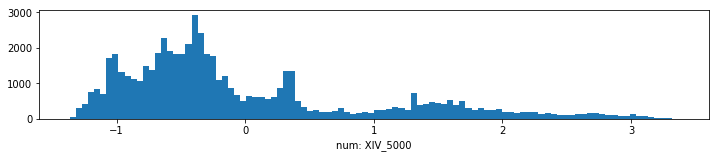

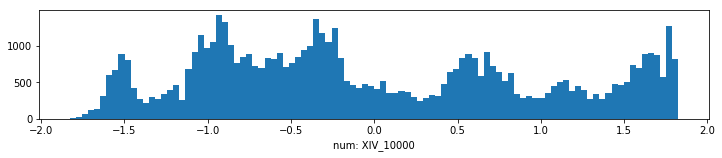

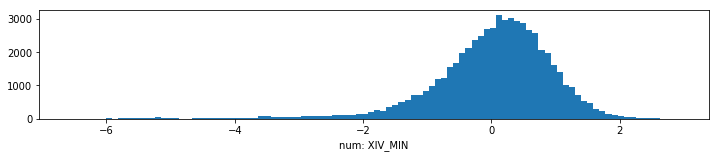

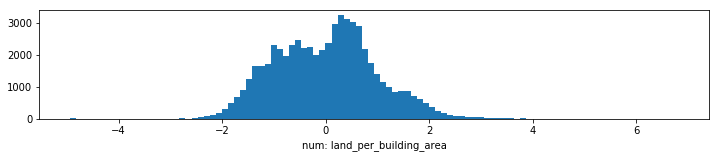

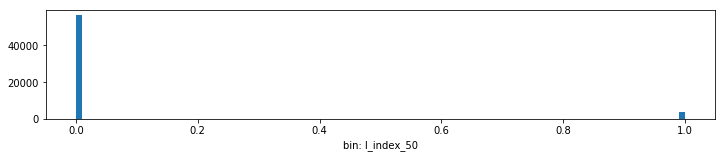

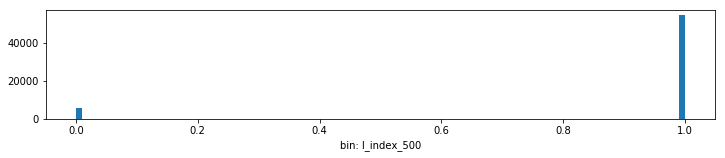

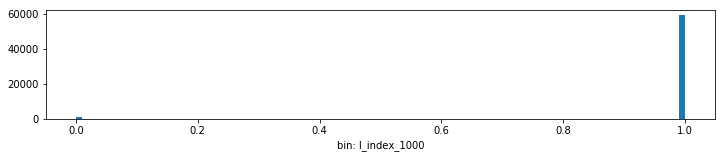

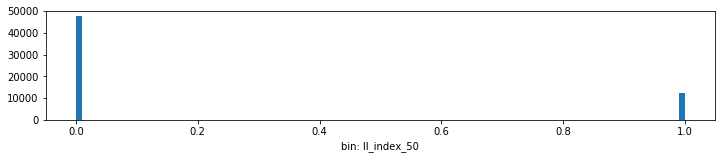

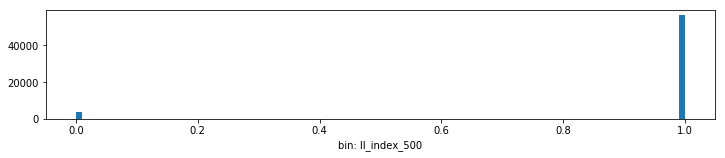

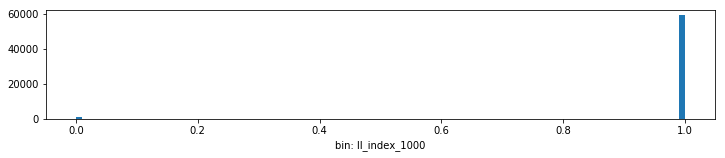

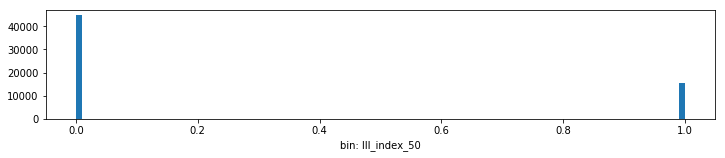

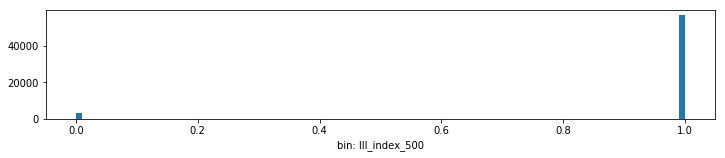

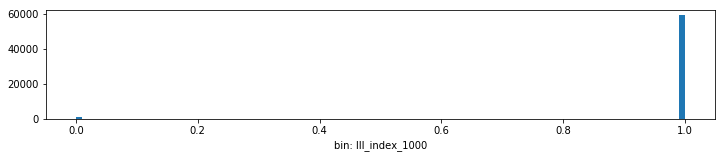

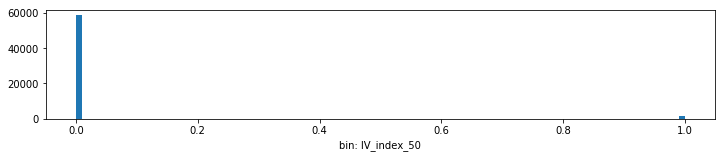

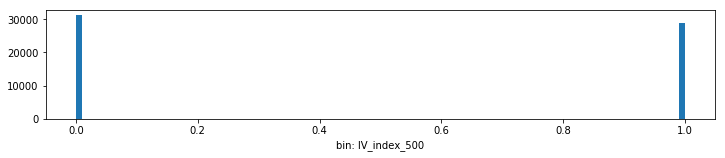

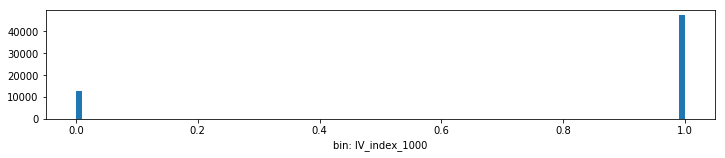

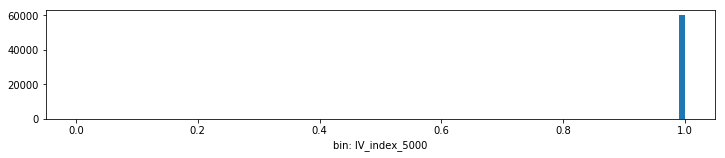

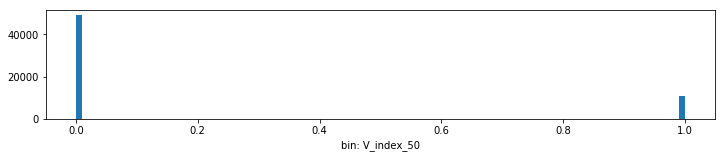

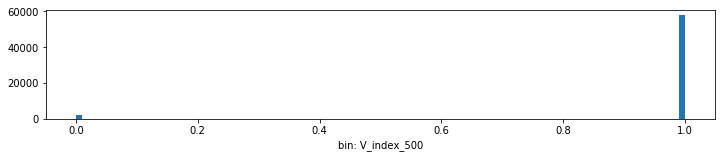

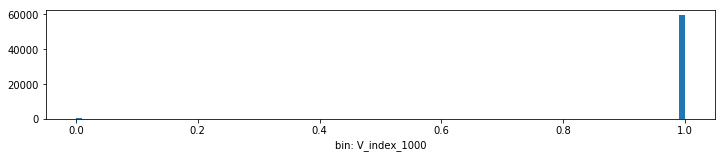

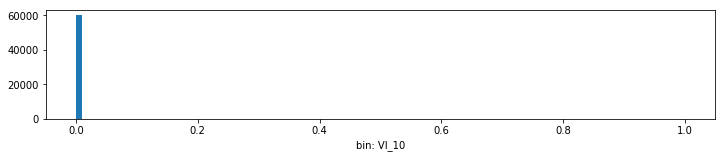

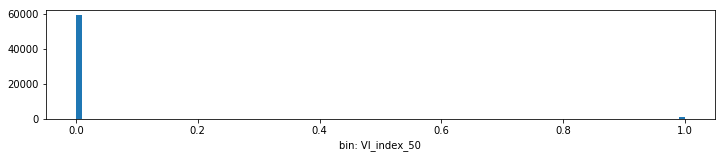

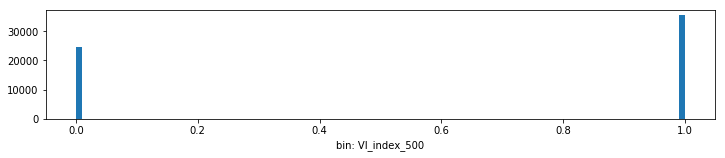

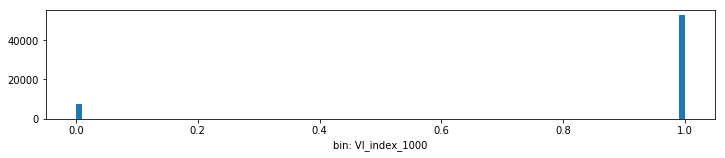

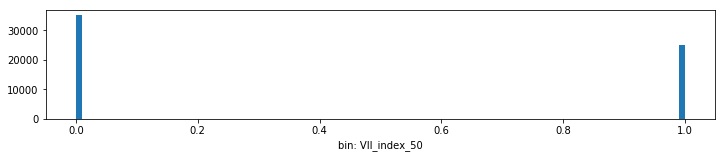

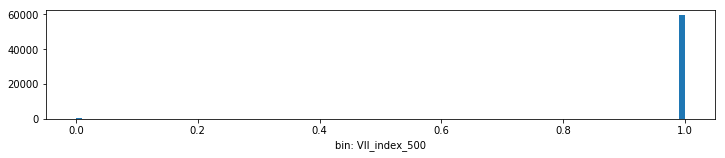

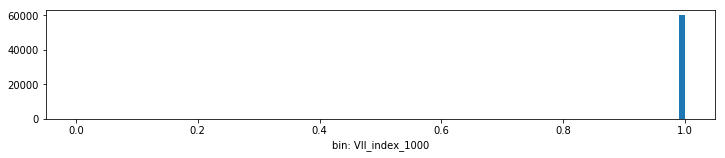

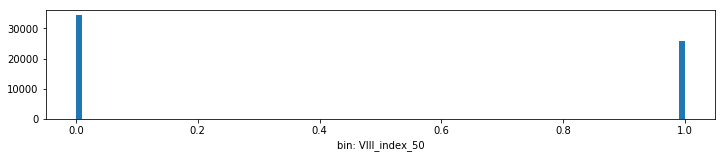

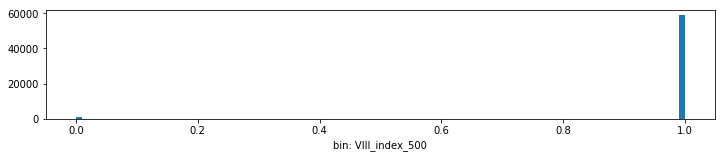

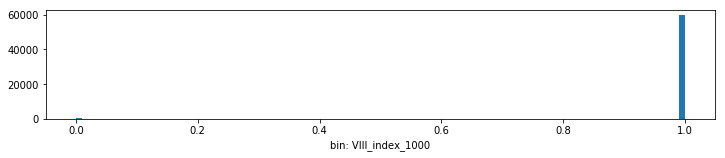

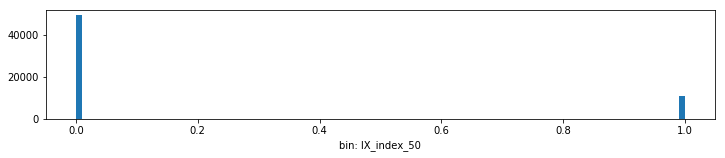

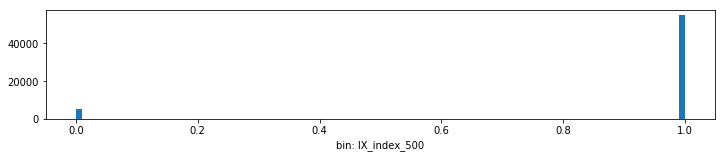

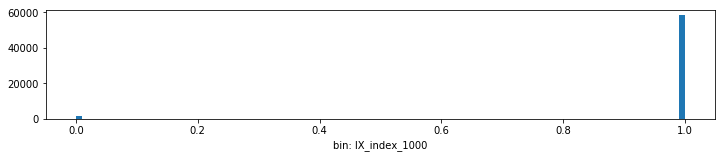

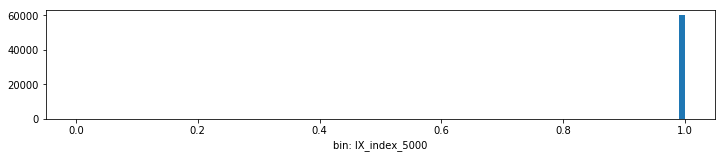

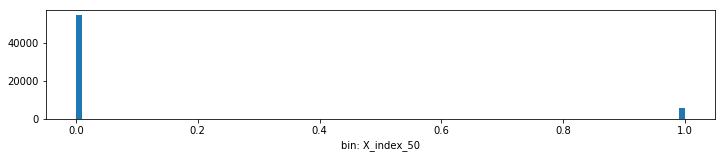

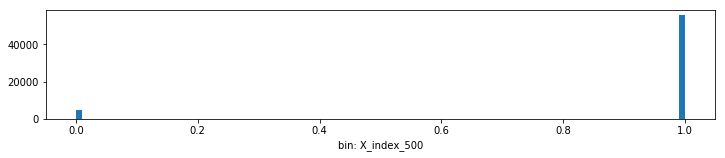

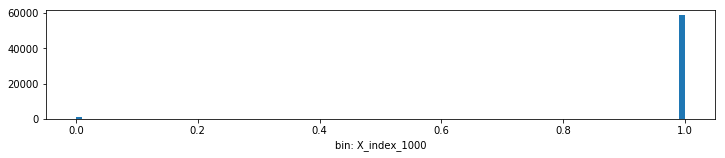

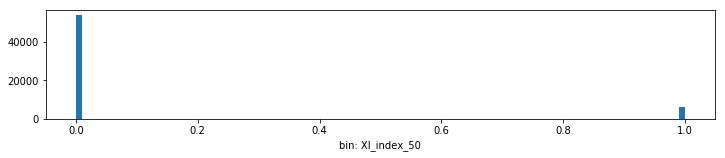

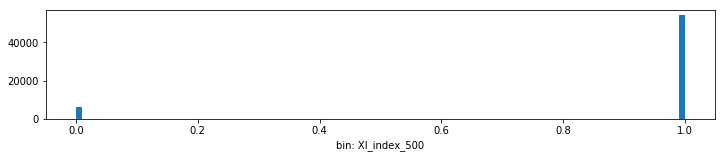

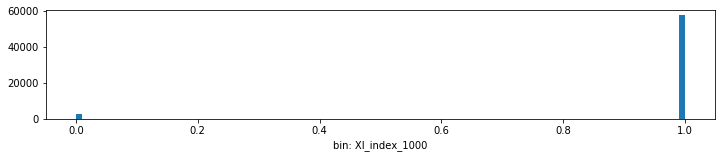

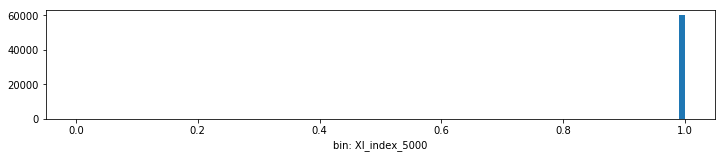

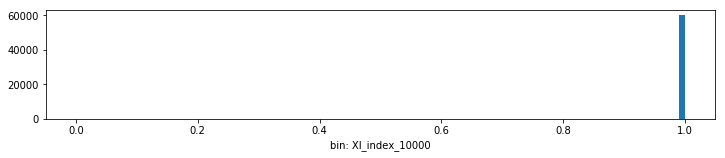

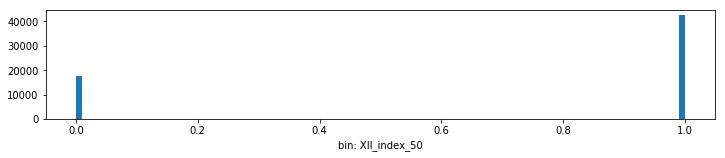

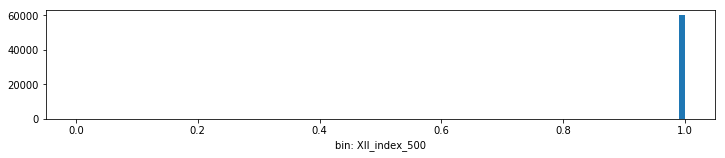

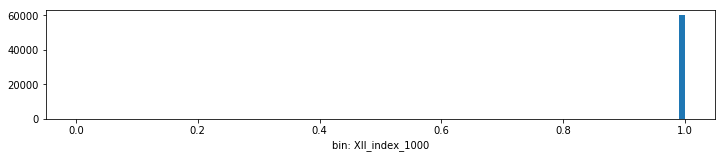

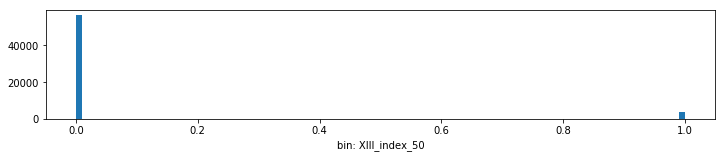

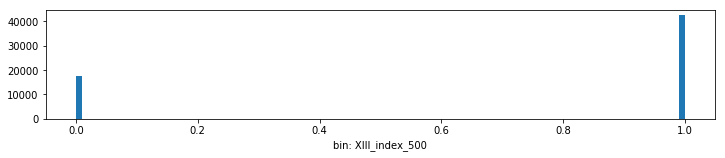

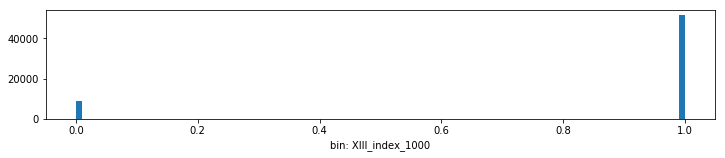

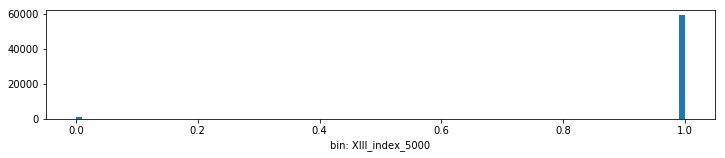

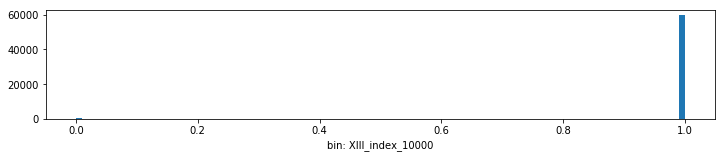

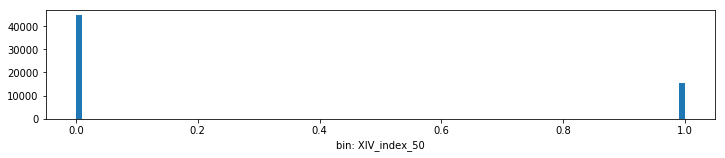

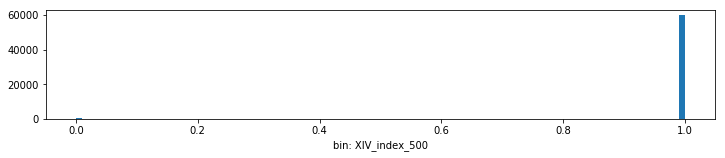

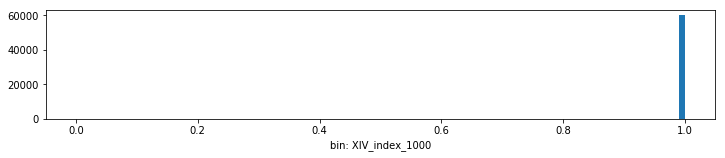

In [61]:
for c in cols_num:
    plt.figure(figsize=(12, 2))
    plt.hist(dfp2[c], bins=100)
    plt.xlabel('num: '+c); plt.show()
for c in cols_bin:
    plt.figure(figsize=(12, 2))
    plt.hist(dfp2[c], bins=100)
    plt.xlabel('bin: '+c); plt.show()

In [62]:
for c in cols_tar_encoded:
    plt.figure(figsize=(12, 2))
    plt.hist(dfp2[c], bins=100)
    plt.xlabel('tar: '+c); plt.show()

### Keras Model

In [28]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Reshape, concatenate
from keras.optimizers import Adam, SGD
print('keras:', keras.__version__, 'tensorflow:', tf.__version__)

keras: 2.2.2 tensorflow: 1.10.1


In [27]:
from keras_get_best import GetBest

def build_model(n_cols_num_bin, cat_n_classes={}, cat_embed_sizes={}, 
                n_neurons=(512,)*10, learning_rate=0.001, optimizer=Adam):
    '''Args: 
       n_cols_num_bin: number of numerical and binary features
       cat_n_classes: dict of cat column name to number of classes in the cat column
       cat_embed_sizes: dict of cat column name to embedding output size
       n_neurons: list of number of neurons for each dense layer
    '''
    is_embedding = len(cat_n_classes) > 0
    num_bin_input = Input(shape=(n_cols_num_bin,), dtype='float32', name='num_bin')
    cats_inputs = {c: Input(shape=(1,), dtype='int32', name=c) for c in cat_n_classes}
    if is_embedding:
        cats_embedding_layers = [
            Reshape(target_shape=(cat_embed_sizes[c],))(
                Embedding(input_dim=c_input_dim, output_dim=cat_embed_sizes[c])(cats_inputs[c])
            ) 
            for c, c_input_dim in cat_n_classes.items()
        ]
        x_layer = concatenate([num_bin_input]+cats_embedding_layers)  # output shape = 258
    else:
        x_layer = num_bin_input
    for n in n_neurons:
        x_layer = Dense(n, activation='relu')(x_layer)
    output = Dense(1)(x_layer)
    model = Model(inputs=[num_bin_input]+list(cats_inputs.values()),
                  outputs=output)
    model.compile(optimizer=optimizer(lr=learning_rate), loss='mae', metrics=['mse'])
    return model    

def build_features_matrices(df, cols_num, cols_cat, cols_bin):
    Xs = {'num_bin': df[cols_num+cols_bin].values}
    for c in cols_cat:
        Xs[c] = df[c].values
    return Xs

def plot_keras_hist(hists, ylim=None, metrics_plot=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].history.keys() if not c.startswith('val')]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for i, hist in enumerate(hists):
            for c in hist.history:
                if c.endswith(m):
                    plt.plot(hist.history[c], label=c+' '+str(i), alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

### Params

In [100]:
params = {'epochs': 500,
          'n_neurons': (1024,)*5+(512,)*5,
          'optimizer': Adam,
          'learning_rate': 0.001,
          'batch_size': 64,
         }

### kfold cross-predict

In [104]:
t0 = time.time()

predicts_val = []
predicts_test = test[['building_id']].copy()
hists = []
best_iterations = []
scores = []
for i, id_fold in enumerate(id_cv):
    print('==== Fold', i+1, '====')
    
    # split train, val
    df_train = train.loc[~train['building_id'].isin(id_fold)].copy().reset_index(drop=True)
    df_val = train.loc[train['building_id'].isin(id_fold)].copy().reset_index(drop=True)
    df_test = test.copy()

    # Feature engineering
    feat_eng = FeatureEngineering(cols_num=cols_num, 
                                  cols_cat=cols_cat, 
                                  cols_bin=cols_bin, 
                                  col_target=col_target, 
                                  fillna_values=fillna_values, 
                                  cols_right_skew=cols_right_skew,
                                  is_embedding=is_embedding, 
                                  is_tar_encoded=is_tar_encoded,
                                  rare_village_threshold=rare_village_threshold, 
                                  rare_town_threshold=rare_town_threshold,)
    df_train = feat_eng.fit_transform(df_train, df_val)
    df_val = feat_eng.transform(df_val)
    df_test = feat_eng.transform(df_test)

    # Construct X y matrices
    if is_embedding:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    else:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    y_train = df_train[col_target+'_scaled']
    y_val = df_val[col_target+'_scaled']
    
    # Compute network size
    n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
    if is_embedding:
        cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
        cat_embed_sizes = {c: int(2*np.log(cat_n_classes[c]+1)+1) for c in cat_n_classes}
    else:
        cat_n_classes = {}
        cat_embed_sizes = {}
    print('Numerical input dims:', n_cols_num_bin)
    print('Embeding  input dims:', cat_n_classes)
    print('Embeding output dims:', cat_embed_sizes)
    print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))

    # Build model
    model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, 
                        n_neurons=params['n_neurons'], learning_rate=params['learning_rate'], 
                        optimizer=params['optimizer'])

    # Train model
    hist = model.fit(x=X_train, y=y_train, batch_size=params['batch_size'], epochs=params['epochs'], 
                     verbose=2, validation_data=(X_val, y_val), 
                     callbacks=[GetBest(monitor='val_loss', verbose=0, mode='min')])
    best_iterations.append(np.argmin(hist.history['val_loss'])+1)
    hists.append(hist)

    # Predict on val set
    df_val[col_target+'_scaled_pred'] = model.predict(X_val, batch_size=1024)
    feat_eng.target_inverse_transform(df_val, col_target+'_scaled_pred', col_target+'_pred')
    df_val['total_price_pred'] = post_processing(df_val[col_target+'_pred'], df_val)

    mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
    mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
    mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
    score = cal_score(df_val['total_price'], df_val['total_price_pred'])
    scores.append(score)

    print('(Fold %d) score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (i, score, mse, mae, mape))
    predicts_val.append(pd.DataFrame({'building_id': df_val['building_id'],
                                      'total_price': df_val['total_price'],
                                      'total_price_predict': df_val['total_price_pred']}))

    
    # Predict on test set
    df_test[col_target+'_scaled_pred'] = model.predict(X_test, batch_size=1024)
    feat_eng.target_inverse_transform(df_test, col_target+'_scaled_pred', col_target+'_pred')

    predicts_test['target_{}'.format(i)] = df_test[col_target+'_pred']

t1 = time.time()

==== Fold 1 ====
Numerical input dims: 205
Embeding  input dims: {'building_material': 10, 'city': 12, 'building_type': 6, 'building_use': 11, 'parking_way': 4, 'town': 211, 'village': 2781, 'encoded_latlon': 7}
Embeding output dims: {'building_material': 5, 'city': 6, 'building_type': 4, 'building_use': 5, 'parking_way': 4, 'town': 11, 'village': 16, 'encoded_latlon': 5}
Total embedding output dims: 56
Train on 40000 samples, validate on 20000 samples
Epoch 1/200
 - 50s - loss: 0.2775 - mean_squared_error: 0.1450 - val_loss: 0.2398 - val_mean_squared_error: 0.1046
Epoch 2/200
 - 52s - loss: 0.2171 - mean_squared_error: 0.0889 - val_loss: 0.2334 - val_mean_squared_error: 0.0963
Epoch 3/200
 - 52s - loss: 0.1983 - mean_squared_error: 0.0760 - val_loss: 0.2003 - val_mean_squared_error: 0.0753
Epoch 4/200
 - 50s - loss: 0.1800 - mean_squared_error: 0.0654 - val_loss: 0.1879 - val_mean_squared_error: 0.0696
Epoch 5/200
 - 52s - loss: 0.1745 - mean_squared_error: 0.0613 - val_loss: 0.1866 -

Epoch 68/200
 - 50s - loss: 0.0492 - mean_squared_error: 0.0076 - val_loss: 0.1596 - val_mean_squared_error: 0.0558
Epoch 69/200
 - 49s - loss: 0.0481 - mean_squared_error: 0.0072 - val_loss: 0.1602 - val_mean_squared_error: 0.0559
Epoch 70/200
 - 48s - loss: 0.0481 - mean_squared_error: 0.0073 - val_loss: 0.1620 - val_mean_squared_error: 0.0570
Epoch 71/200
 - 49s - loss: 0.0481 - mean_squared_error: 0.0072 - val_loss: 0.1607 - val_mean_squared_error: 0.0558
Epoch 72/200
 - 49s - loss: 0.0470 - mean_squared_error: 0.0070 - val_loss: 0.1611 - val_mean_squared_error: 0.0562
Epoch 73/200
 - 51s - loss: 0.0472 - mean_squared_error: 0.0076 - val_loss: 0.1595 - val_mean_squared_error: 0.0553
Epoch 74/200
 - 49s - loss: 0.0462 - mean_squared_error: 0.0067 - val_loss: 0.1610 - val_mean_squared_error: 0.0563
Epoch 75/200
 - 49s - loss: 0.0456 - mean_squared_error: 0.0067 - val_loss: 0.1609 - val_mean_squared_error: 0.0568
Epoch 76/200
 - 50s - loss: 0.0451 - mean_squared_error: 0.0064 - val_lo

Epoch 139/200
 - 55s - loss: 0.0312 - mean_squared_error: 0.0036 - val_loss: 0.1582 - val_mean_squared_error: 0.0552
Epoch 140/200
 - 55s - loss: 0.0294 - mean_squared_error: 0.0040 - val_loss: 0.1594 - val_mean_squared_error: 0.0562
Epoch 141/200
 - 65s - loss: 0.0296 - mean_squared_error: 0.0032 - val_loss: 0.1592 - val_mean_squared_error: 0.0554
Epoch 142/200
 - 60s - loss: 0.0306 - mean_squared_error: 0.0107 - val_loss: 0.1589 - val_mean_squared_error: 0.0559
Epoch 143/200
 - 53s - loss: 0.0301 - mean_squared_error: 0.0034 - val_loss: 0.1593 - val_mean_squared_error: 0.0558
Epoch 144/200
 - 58s - loss: 0.0298 - mean_squared_error: 0.0033 - val_loss: 0.1587 - val_mean_squared_error: 0.0555
Epoch 145/200
 - 52s - loss: 0.0288 - mean_squared_error: 0.0031 - val_loss: 0.1578 - val_mean_squared_error: 0.0553
Epoch 146/200
 - 49s - loss: 0.0304 - mean_squared_error: 0.0033 - val_loss: 0.1578 - val_mean_squared_error: 0.0550
Epoch 147/200
 - 52s - loss: 0.0295 - mean_squared_error: 0.0032

 - 46s - loss: 0.1945 - mean_squared_error: 0.0729 - val_loss: 0.2105 - val_mean_squared_error: 0.0841
Epoch 4/200
 - 47s - loss: 0.1823 - mean_squared_error: 0.0658 - val_loss: 0.1933 - val_mean_squared_error: 0.0726
Epoch 5/200
 - 46s - loss: 0.1740 - mean_squared_error: 0.0607 - val_loss: 0.1913 - val_mean_squared_error: 0.0723
Epoch 6/200
 - 46s - loss: 0.1675 - mean_squared_error: 0.0568 - val_loss: 0.1876 - val_mean_squared_error: 0.0719
Epoch 7/200
 - 46s - loss: 0.1599 - mean_squared_error: 0.0528 - val_loss: 0.1812 - val_mean_squared_error: 0.0668
Epoch 8/200
 - 46s - loss: 0.1553 - mean_squared_error: 0.0497 - val_loss: 0.1900 - val_mean_squared_error: 0.0709
Epoch 9/200
 - 46s - loss: 0.1490 - mean_squared_error: 0.0462 - val_loss: 0.1720 - val_mean_squared_error: 0.0621
Epoch 10/200
 - 46s - loss: 0.1444 - mean_squared_error: 0.0441 - val_loss: 0.1837 - val_mean_squared_error: 0.0676
Epoch 11/200
 - 46s - loss: 0.1392 - mean_squared_error: 0.0414 - val_loss: 0.1710 - val_me

Epoch 74/200
 - 46s - loss: 0.0473 - mean_squared_error: 0.0069 - val_loss: 0.1601 - val_mean_squared_error: 0.0574
Epoch 75/200
 - 46s - loss: 0.0472 - mean_squared_error: 0.0068 - val_loss: 0.1598 - val_mean_squared_error: 0.0573
Epoch 76/200
 - 46s - loss: 0.0459 - mean_squared_error: 0.0065 - val_loss: 0.1596 - val_mean_squared_error: 0.0575
Epoch 77/200
 - 46s - loss: 0.0457 - mean_squared_error: 0.0065 - val_loss: 0.1607 - val_mean_squared_error: 0.0577
Epoch 78/200
 - 46s - loss: 0.0455 - mean_squared_error: 0.0063 - val_loss: 0.1591 - val_mean_squared_error: 0.0566
Epoch 79/200
 - 46s - loss: 0.0443 - mean_squared_error: 0.0061 - val_loss: 0.1598 - val_mean_squared_error: 0.0569
Epoch 80/200
 - 46s - loss: 0.0449 - mean_squared_error: 0.0062 - val_loss: 0.1596 - val_mean_squared_error: 0.0573
Epoch 81/200
 - 45s - loss: 0.0439 - mean_squared_error: 0.0060 - val_loss: 0.1600 - val_mean_squared_error: 0.0573
Epoch 82/200
 - 47s - loss: 0.0435 - mean_squared_error: 0.0059 - val_lo

Epoch 145/200
 - 46s - loss: 0.0296 - mean_squared_error: 0.0032 - val_loss: 0.1582 - val_mean_squared_error: 0.0568
Epoch 146/200
 - 46s - loss: 0.0304 - mean_squared_error: 0.0033 - val_loss: 0.1572 - val_mean_squared_error: 0.0562
Epoch 147/200
 - 46s - loss: 0.0304 - mean_squared_error: 0.0033 - val_loss: 0.1588 - val_mean_squared_error: 0.0574
Epoch 148/200
 - 46s - loss: 0.0295 - mean_squared_error: 0.0031 - val_loss: 0.1579 - val_mean_squared_error: 0.0567
Epoch 149/200
 - 47s - loss: 0.0295 - mean_squared_error: 0.0032 - val_loss: 0.1567 - val_mean_squared_error: 0.0561
Epoch 150/200
 - 47s - loss: 0.0292 - mean_squared_error: 0.0031 - val_loss: 0.1574 - val_mean_squared_error: 0.0563
Epoch 151/200
 - 46s - loss: 0.0284 - mean_squared_error: 0.0031 - val_loss: 0.1575 - val_mean_squared_error: 0.0564
Epoch 152/200
 - 46s - loss: 0.0289 - mean_squared_error: 0.0031 - val_loss: 0.1587 - val_mean_squared_error: 0.0574
Epoch 153/200
 - 46s - loss: 0.0293 - mean_squared_error: 0.0030

Epoch 10/200
 - 46s - loss: 0.1433 - mean_squared_error: 0.0433 - val_loss: 0.1725 - val_mean_squared_error: 0.0634
Epoch 11/200
 - 46s - loss: 0.1393 - mean_squared_error: 0.0410 - val_loss: 0.1719 - val_mean_squared_error: 0.0632
Epoch 12/200
 - 47s - loss: 0.1350 - mean_squared_error: 0.0390 - val_loss: 0.1827 - val_mean_squared_error: 0.0685
Epoch 13/200
 - 47s - loss: 0.1315 - mean_squared_error: 0.0372 - val_loss: 0.1700 - val_mean_squared_error: 0.0621
Epoch 14/200
 - 47s - loss: 0.1268 - mean_squared_error: 0.0351 - val_loss: 0.1740 - val_mean_squared_error: 0.0635
Epoch 15/200
 - 46s - loss: 0.1235 - mean_squared_error: 0.0338 - val_loss: 0.1724 - val_mean_squared_error: 0.0629
Epoch 16/200
 - 46s - loss: 0.1191 - mean_squared_error: 0.0316 - val_loss: 0.1808 - val_mean_squared_error: 0.0686
Epoch 17/200
 - 47s - loss: 0.1166 - mean_squared_error: 0.0304 - val_loss: 0.1737 - val_mean_squared_error: 0.0652
Epoch 18/200
 - 47s - loss: 0.1134 - mean_squared_error: 0.0292 - val_lo

Epoch 81/200
 - 48s - loss: 0.0440 - mean_squared_error: 0.0058 - val_loss: 0.1604 - val_mean_squared_error: 0.0586
Epoch 82/200
 - 47s - loss: 0.0427 - mean_squared_error: 0.0059 - val_loss: 0.1590 - val_mean_squared_error: 0.0589
Epoch 83/200
 - 48s - loss: 0.0427 - mean_squared_error: 0.0055 - val_loss: 0.1599 - val_mean_squared_error: 0.0588
Epoch 84/200
 - 47s - loss: 0.0426 - mean_squared_error: 0.0054 - val_loss: 0.1597 - val_mean_squared_error: 0.0587
Epoch 85/200
 - 47s - loss: 0.0423 - mean_squared_error: 0.0054 - val_loss: 0.1603 - val_mean_squared_error: 0.0589
Epoch 86/200
 - 47s - loss: 0.0423 - mean_squared_error: 0.0053 - val_loss: 0.1595 - val_mean_squared_error: 0.0588
Epoch 87/200
 - 47s - loss: 0.0421 - mean_squared_error: 0.0064 - val_loss: 0.1606 - val_mean_squared_error: 0.0596
Epoch 88/200
 - 47s - loss: 0.0413 - mean_squared_error: 0.0051 - val_loss: 0.1585 - val_mean_squared_error: 0.0580
Epoch 89/200
 - 47s - loss: 0.0408 - mean_squared_error: 0.0050 - val_lo

Epoch 152/200
 - 46s - loss: 0.0299 - mean_squared_error: 0.0030 - val_loss: 0.1576 - val_mean_squared_error: 0.0579
Epoch 153/200
 - 47s - loss: 0.0305 - mean_squared_error: 0.0031 - val_loss: 0.1569 - val_mean_squared_error: 0.0577
Epoch 154/200
 - 47s - loss: 0.0298 - mean_squared_error: 0.0030 - val_loss: 0.1570 - val_mean_squared_error: 0.0577
Epoch 155/200
 - 47s - loss: 0.0309 - mean_squared_error: 0.0032 - val_loss: 0.1577 - val_mean_squared_error: 0.0582
Epoch 156/200
 - 47s - loss: 0.0295 - mean_squared_error: 0.0031 - val_loss: 0.1580 - val_mean_squared_error: 0.0580
Epoch 157/200
 - 46s - loss: 0.0292 - mean_squared_error: 0.0029 - val_loss: 0.1572 - val_mean_squared_error: 0.0574
Epoch 158/200
 - 46s - loss: 0.0304 - mean_squared_error: 0.0031 - val_loss: 0.1576 - val_mean_squared_error: 0.0581
Epoch 159/200
 - 47s - loss: 0.0298 - mean_squared_error: 0.0030 - val_loss: 0.1575 - val_mean_squared_error: 0.0577
Epoch 160/200
 - 46s - loss: 0.0309 - mean_squared_error: 0.0031

In [105]:
print('Total computing time:', t1-t0)

Total computing time: 28579.714686870575


In [106]:
print('Kfold cv score (mean, stdev):', np.mean(scores), np.std(scores)) # 5868.87314

(('epochs', 200), ('n_neurons', (1024, 1024, 1024, 1024, 1024, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.001), ('batch_size', 64)) 5010.503401721518 0.052174035 0.15091588 0.011324741 [4954.842085674405, 5003.840687379241, 5072.827432110906] [0.051094234, 0.052469276, 0.0529586] [0.15171897, 0.1507649, 0.15026379] [0.011382295, 0.011312374, 0.011279553]


In [108]:
predicts_test.head()

,batch_size,score,mse,mae,mape
0,64,5010.503402,0.052174,0.150916,0.011325


In [ ]:
pd.concat(predicts_val, axis=0).to_csv('output/'+model_name+'-cv.csv', index=False)

predicts_test['target_mean'] = \
    predicts_test[['target_'+str(i) for i in range(len(id_cv))]].mean(axis=1)
predicts_test['total_price'] = post_processing(predicts_test['target_mean'].values, df_test)
predicts_test[['building_id', 'total_price']].to_csv('output/'+model_name+'-test-kfold.csv', index=False)

In [ ]:
print('Best iterations:', best_iterations)
print('Mean best iterations:', int(np.mean(best_iterations)))

#### Hist

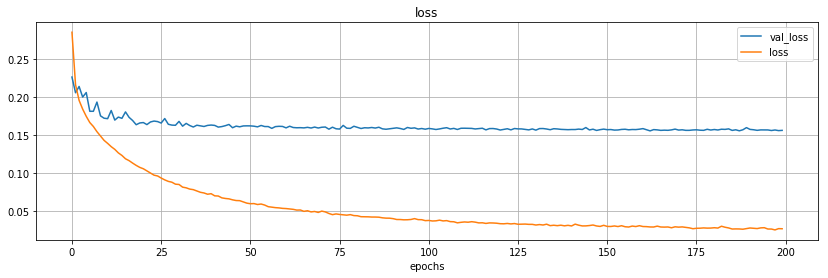

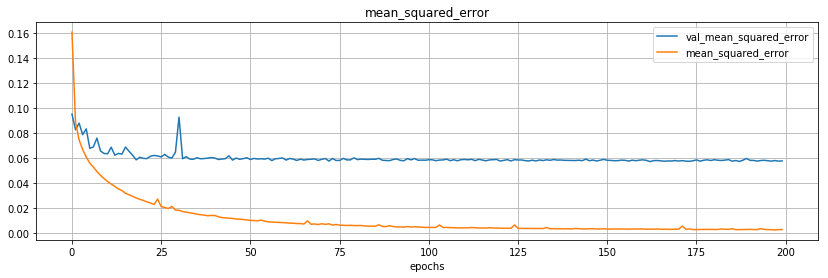

In [112]:
plot_keras_hist(hists)

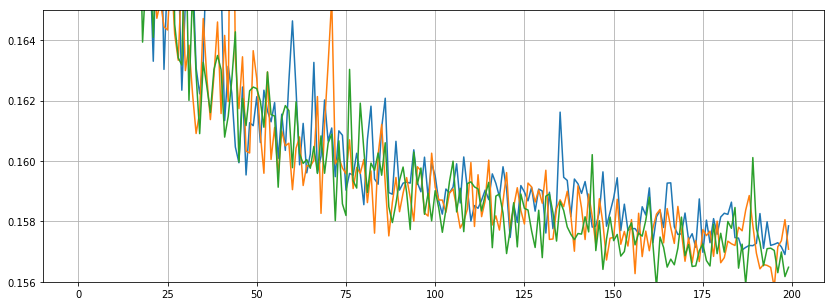

In [114]:
plot_keras_hist(hists, ylim=(hists[0].history['val_loss'].min()-0.005, 
                             hists[0].history['val_loss'].min()+0.005), metrics_plot=['val_loss'])

### One-fold prediction

In [ ]:
params['epochs'] = int(np.mean(best_iterations)*1.15)

In [ ]:
params

In [ ]:
df_train = train.copy()
df_test = test.copy()

# Feature eng
feat_eng = FeatureEngineering(cols_num=cols_num, 
                              cols_cat=cols_cat, 
                              cols_bin=cols_bin, 
                              col_target=col_target, 
                              fillna_values=fillna_values, 
                              cols_right_skew=cols_right_skew,
                              is_embedding=is_embedding, 
                              is_tar_encoded=is_tar_encoded,
                              rare_village_threshold=rare_village_threshold, 
                              rare_town_threshold=rare_town_threshold,)
df_train = feat_eng.fit_transform(df_train, df_test)
df_test = feat_eng.transform(df_test)

# Construct X y matrices
if is_embedding:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
else:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    X_test = build_features_matrices(df_test, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
y_train = df_train[col_target+'_scaled']

# Compute network size
n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
if is_embedding:
    cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
    cat_embed_sizes = {c: int(2*np.log(cat_n_classes[c]+1)+1) for c in cat_n_classes}
else:
    cat_n_classes = {}
    cat_embed_sizes = {}
print('Numerical input dims:', n_cols_num_bin)
print('Embeding  input dims:', cat_n_classes)
print('Embeding output dims:', cat_embed_sizes)
print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))

# Build model
model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, 
                    n_neurons=params['n_neurons'], learning_rate=params['learning_rate'], 
                    optimizer=params['optimizer'])

# Train model
hist = model.fit(x=X_train, y=y_train, batch_size=params['batch_size'], epochs=params['epochs'], 
                 verbose=2)

# Predict on test set
df_test[col_target+'_scaled_pred'] = model.predict(X_test, batch_size=1024)
feat_eng.target_inverse_transform(df_test, col_target+'_scaled_pred', col_target+'_pred')
df_test['total_price_pred'] = post_processing(df_test[col_target+'_pred'], df_test)

df_test_pred = pd.DataFrame({'building_id': df_test['building_id'], 
                             'total_price': df_test['total_price_pred']})
display(df_test_pred.head(20))

In [ ]:
df_test_pred.to_csv('output/'+model_name+'-test-one.csv', index=False)

### Result

Round 2:

(('epochs', 200), ('n_neurons', (1024, 1024, 1024, 1024, 1024, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.001), ('batch_size', 64)) 5010.503401721518 0.052174035 0.15091588 0.011324741 [4954.842085674405, 5003.840687379241, 5072.827432110906] [0.051094234, 0.052469276, 0.0529586] [0.15171897, 0.1507649, 0.15026379] [0.011382295, 0.011312374, 0.011279553]

### Hist

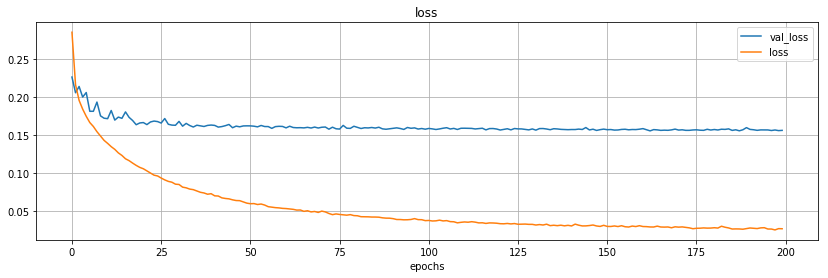

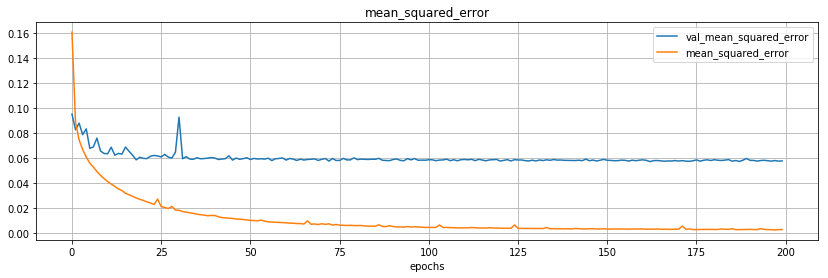

In [112]:
plot_keras_hist(hist)

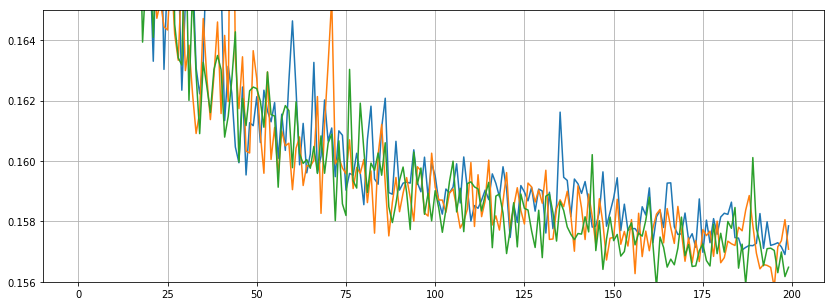

In [114]:
plot_keras_hist(hist, ylim=(hist.history['loss'].min()-0.005, 
                            hist.history['loss'].min()+0.005), metrics_plot=['loss'])